<div id = 3 style="color:white;
           display:fill;
           border-radius:20px;
           background-color:#b02222;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 6rem;
              color:white;
          text-align:center;
          margin:10 auto;
          ">
    ITERATION 6: Focus on identifying and removing/imputing outliers


</h2>
</div>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
import missingno as msno

import warnings

from functions_20221018_D import get_columns, add_supplements, feature_engineer

In [2]:
VERSION = '05'

warnings.filterwarnings("ignore")

In [3]:
LABEL = 'Price'

columns, booleans, floats, categories = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)

columns.insert(0, LABEL)
print(colored(f"label", "green"), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [4]:
IN_COLAB = False

filename = f'df_listings_v{VERSION}.csv'
#remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'

df_pathname_raw = f'../../data/source/{filename}'
#df_pathname_tidy = f'../../data/final/{filename}'

df_orig = pd.read_csv(df_pathname_raw, on_bad_lines='error', index_col=0)

In [5]:
df = add_supplements(df_orig)
df = feature_engineer(df, version=VERSION)

In [6]:
df = df[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54067 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                54067 non-null  int64  
 1   bedrooms             52265 non-null  float64
 2   bathrooms            50569 non-null  float64
 3   nearestStation       54067 non-null  float64
 4   location.latitude    54057 non-null  float64
 5   location.longitude   54067 non-null  float64
 6   latitude_deviation   54057 non-null  float64
 7   longitude_deviation  54067 non-null  float64
 8   tenure.tenureType    50413 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 4.1+ MB


<AxesSubplot: >

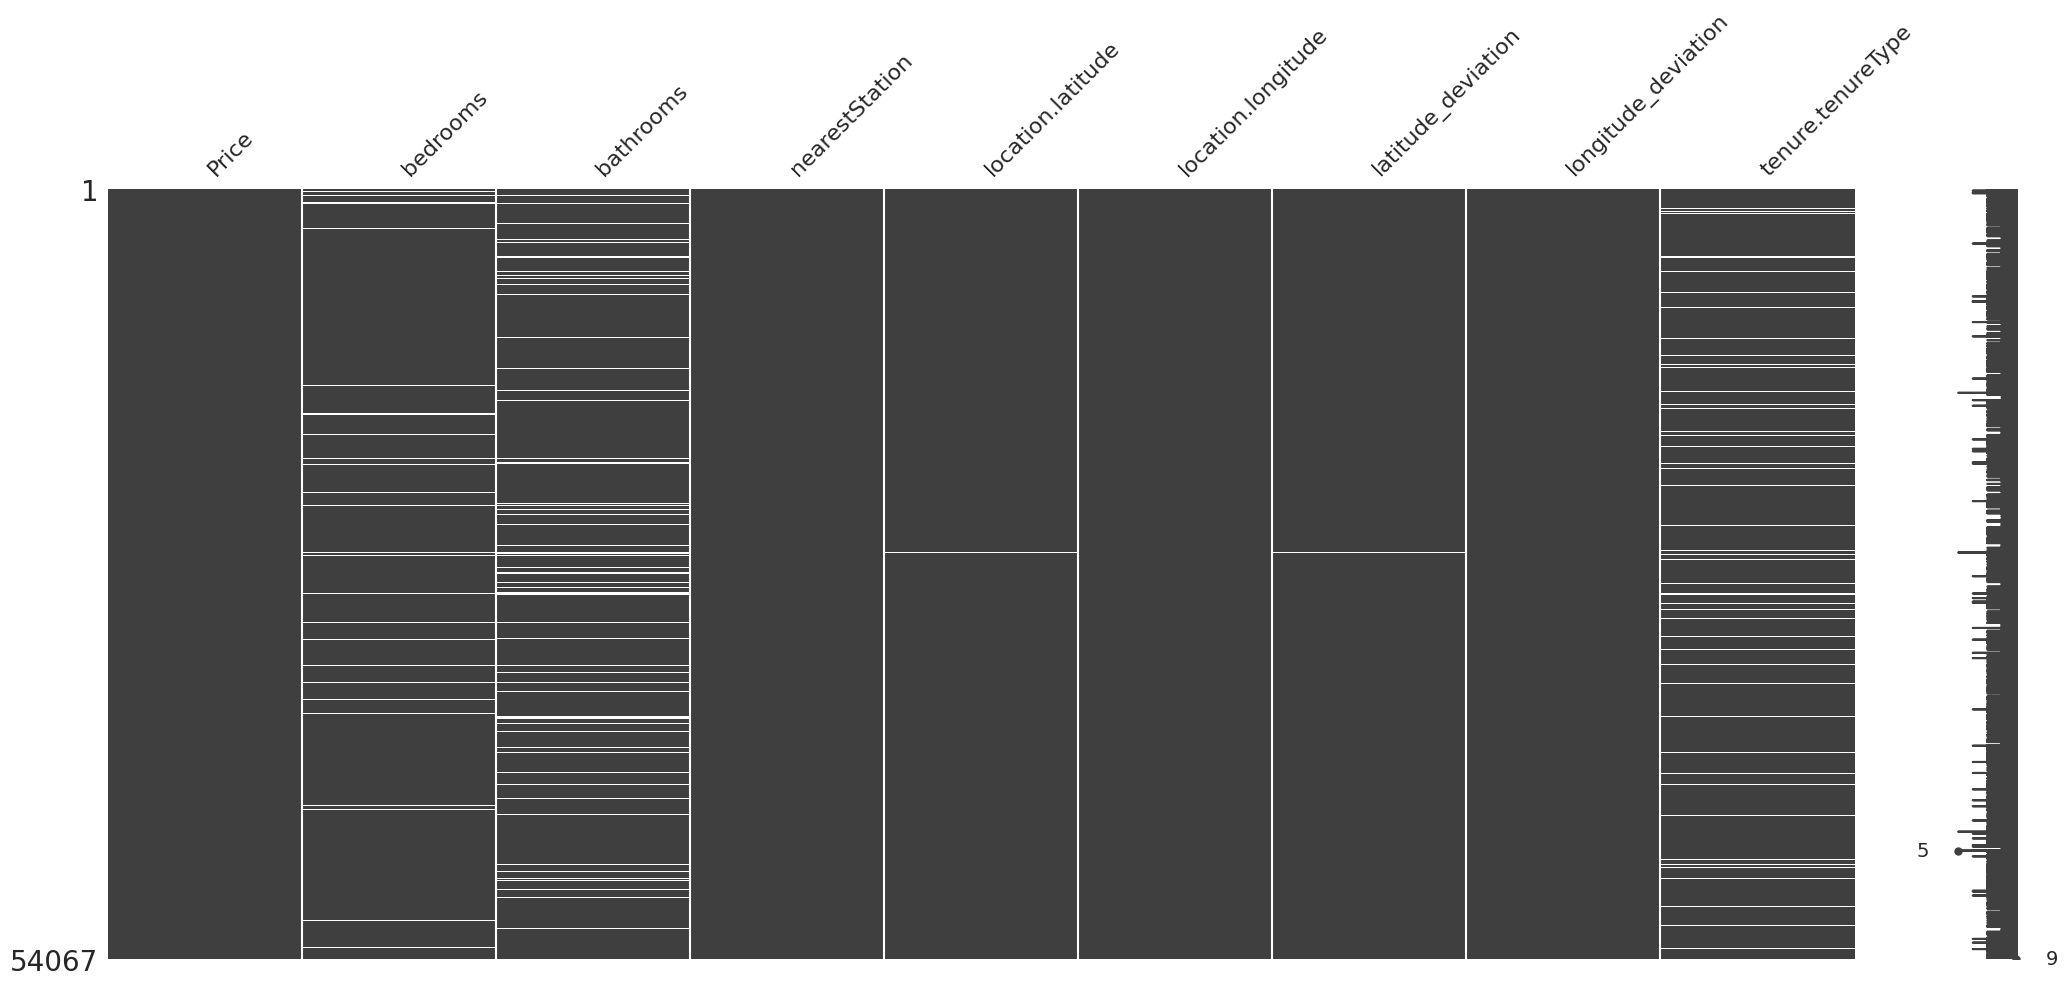

In [7]:
msno.matrix(df)

In [8]:
i = -1

bedrooms


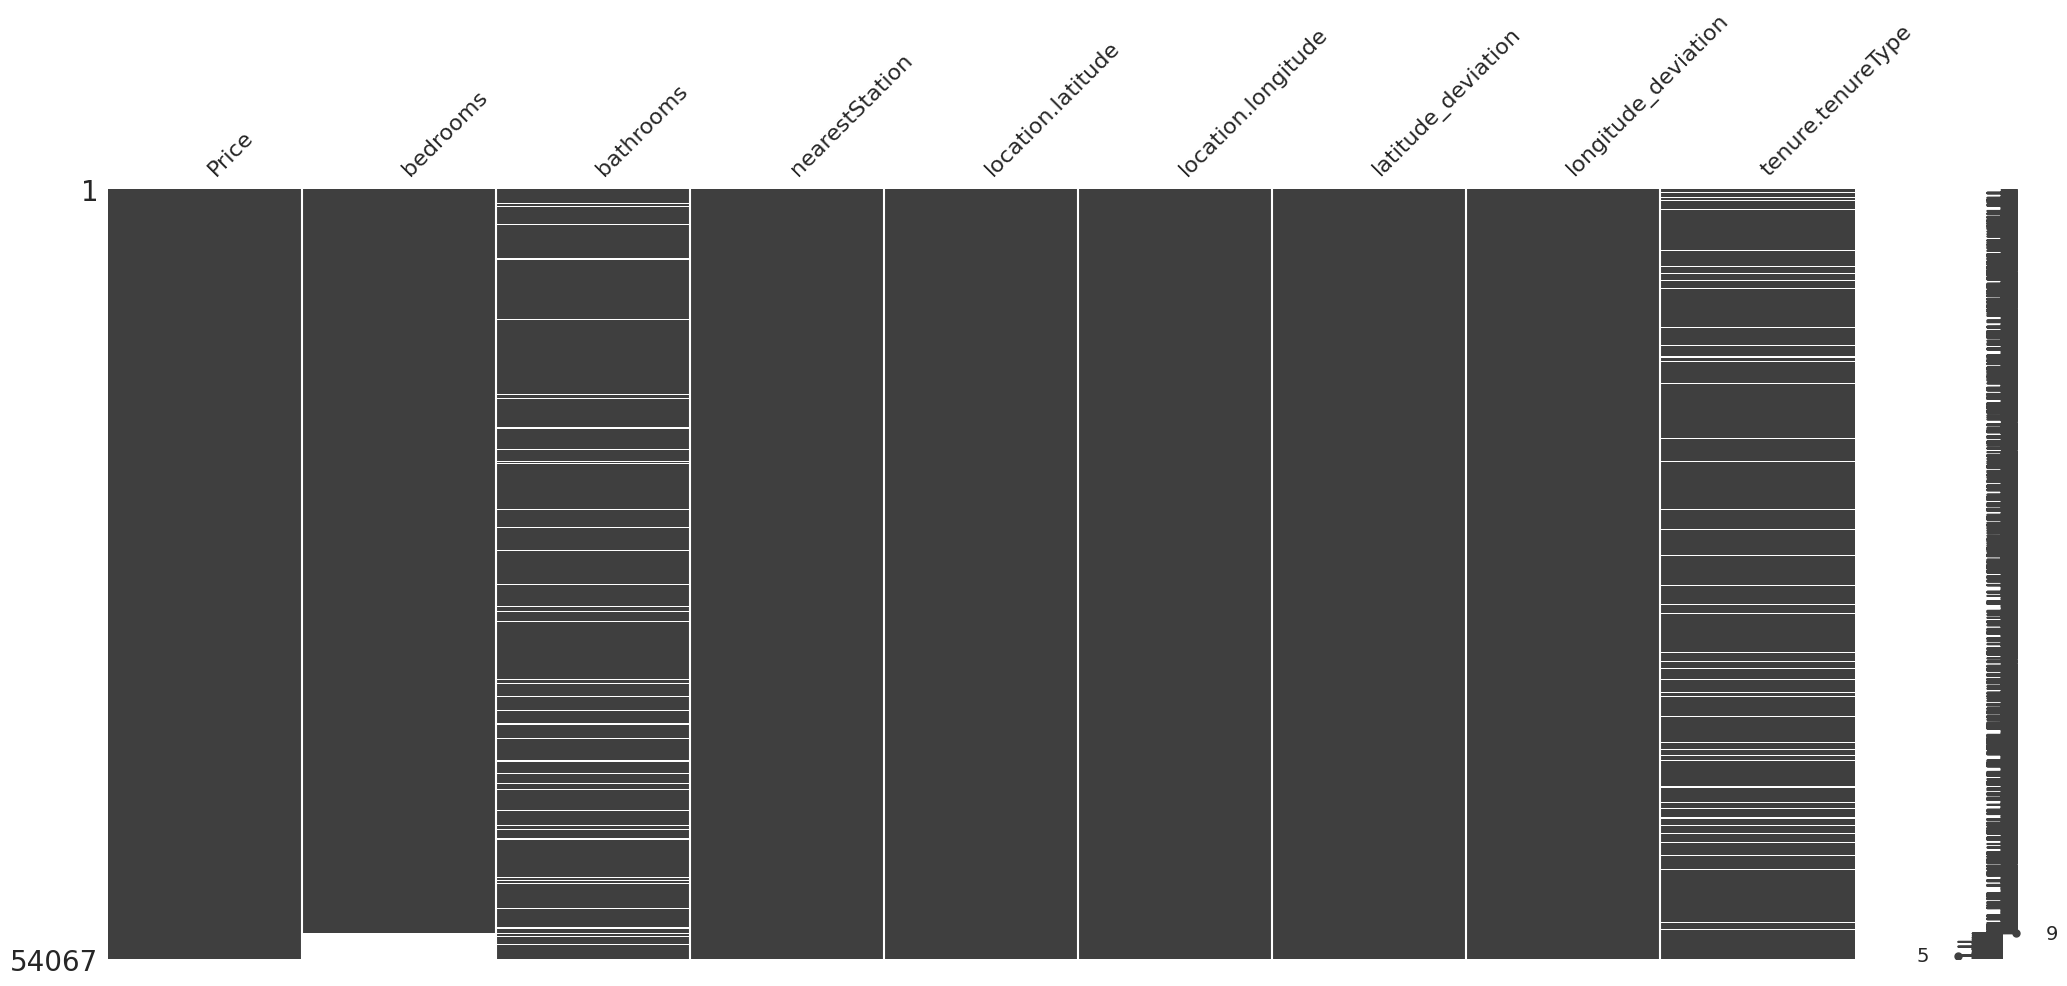

In [9]:
no_cols = ['bedrooms', 'bathrooms', 'tenure.tenureType']
i = (i + 1) % len(no_cols)
# Sort banking by age and visualize
df_sorted = df.sort_values(by=no_cols[i])
msno.matrix(df_sorted)
print(no_cols[i])
plt.show()

bathrooms


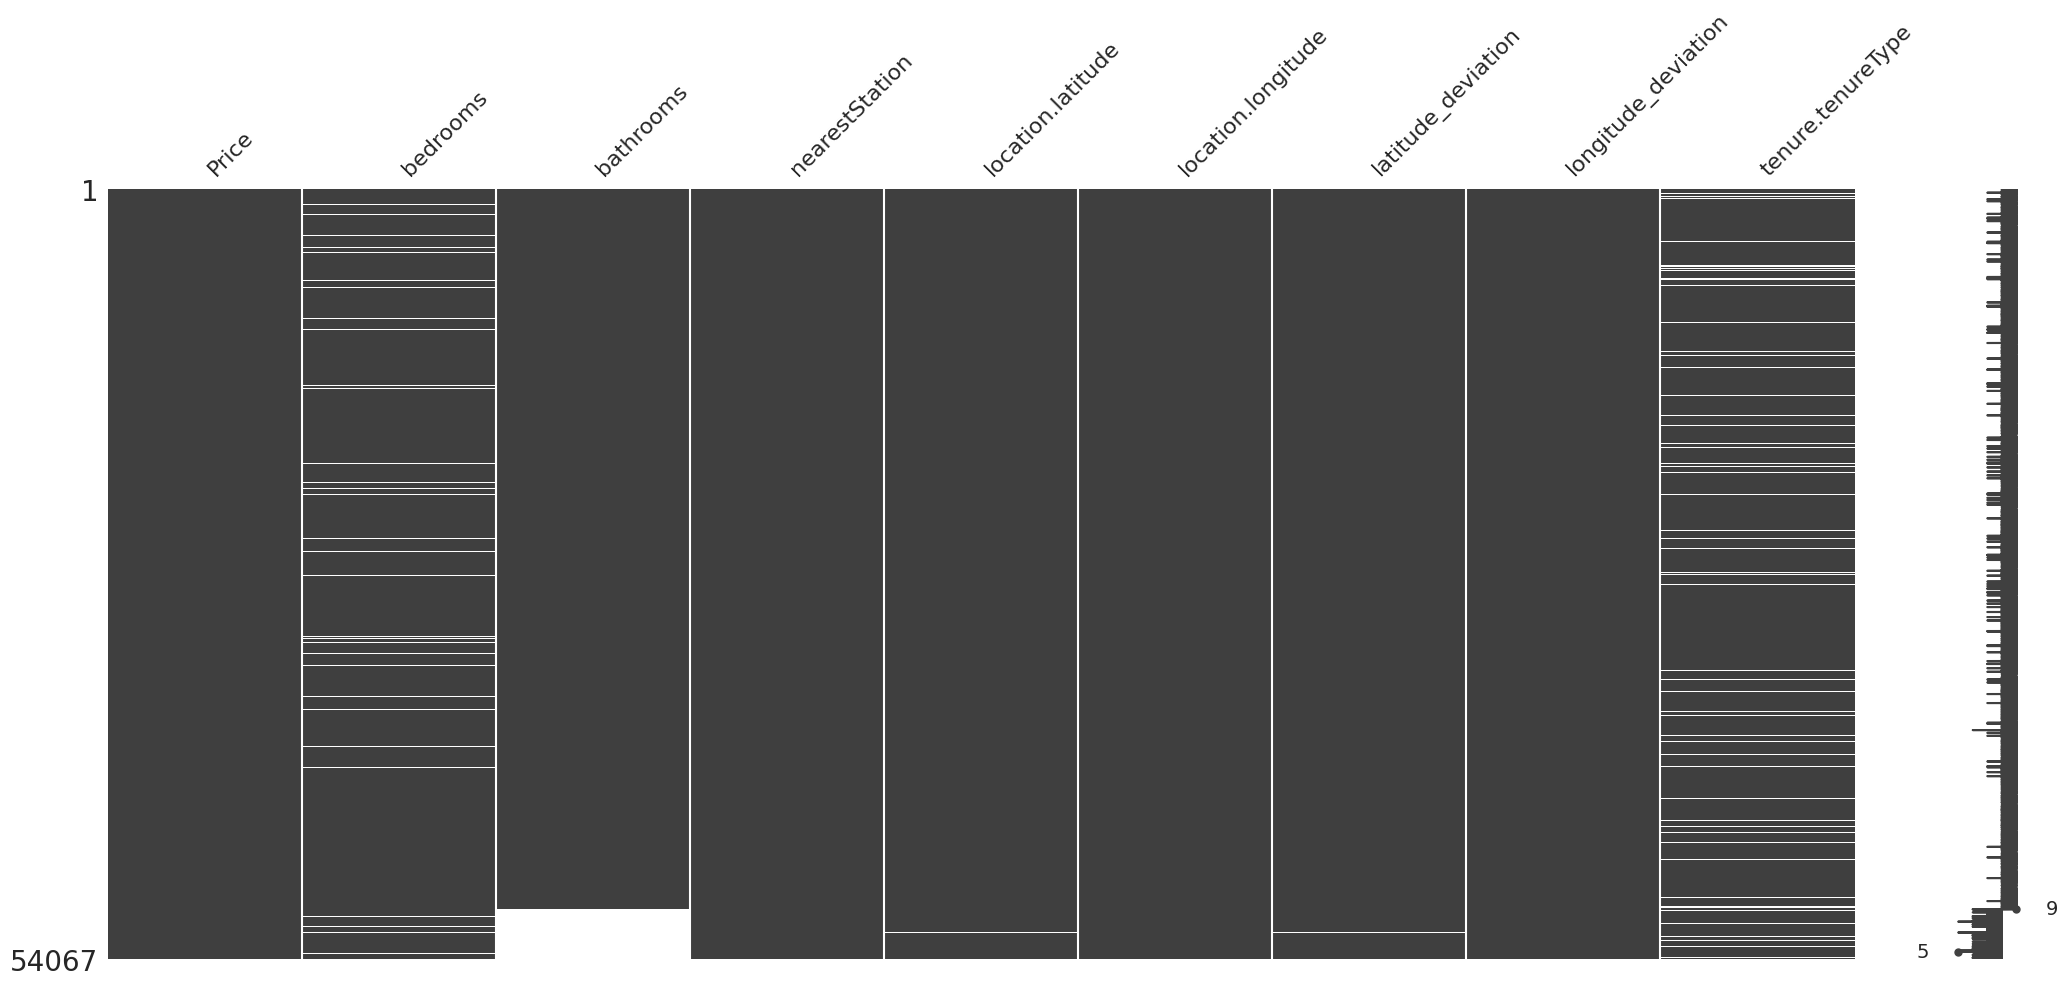

In [10]:
no_cols = ['bedrooms', 'bathrooms', 'tenure.tenureType']
i = (i + 1) % len(no_cols)
# Sort banking by age and visualize
df_sorted = df.sort_values(by=no_cols[i])
msno.matrix(df_sorted)
print(no_cols[i])
plt.show()

Conclusion: the missing data is missing completely at random. There is no correlation between missing data and any other factor which can be identified.

tenure.tenureType


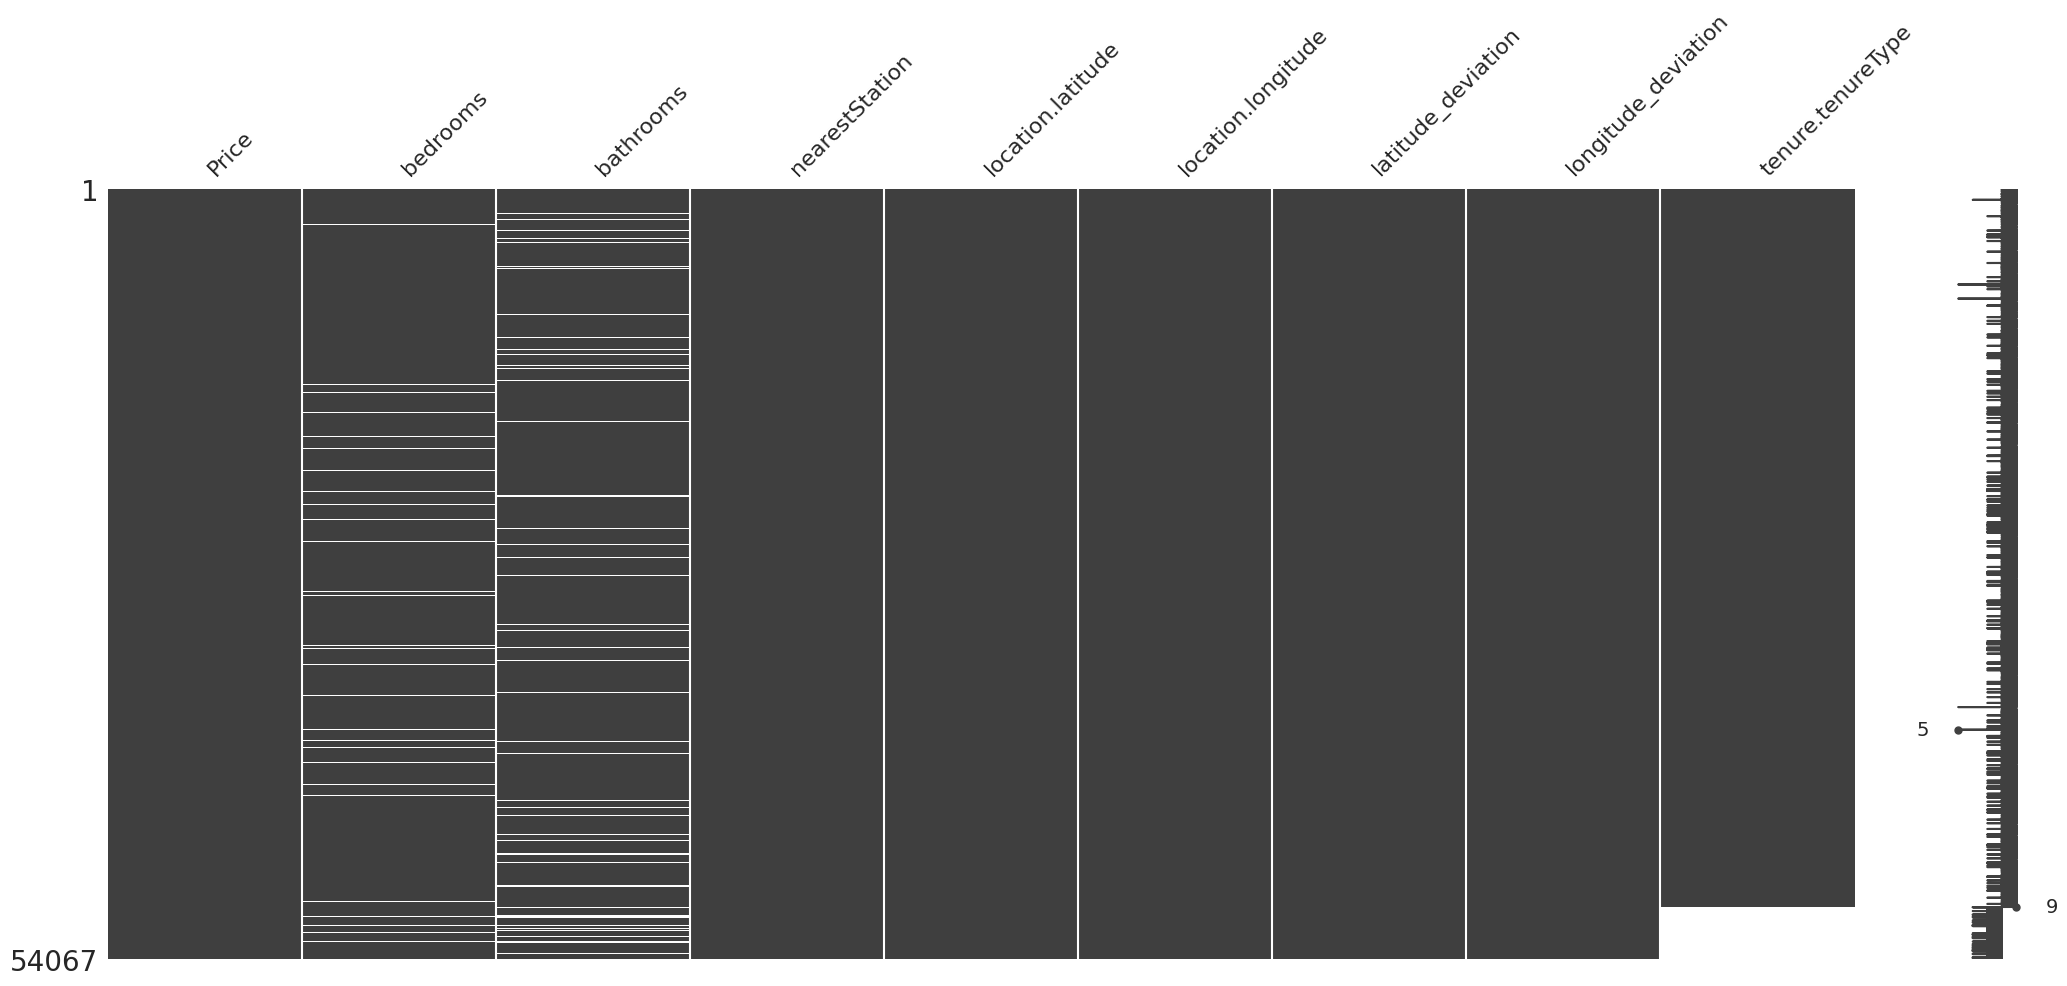

In [11]:
no_cols = ['bedrooms', 'bathrooms', 'tenure.tenureType']
i = (i + 1) % len(no_cols)
# Sort banking by age and visualize
df_sorted = df.sort_values(by=no_cols[i])
msno.matrix(df_sorted)
print(no_cols[i])
plt.show()

In [12]:
if False:
    import numpy as np

    def detect_outliers(name, data, thresholdP=3):
        outliers = []
        threshold = thresholdP
        try:
            mean = np.mean(data)
        except:
            print(f'error on {name}: partially or fully not numeric')
            return []
        std = np.std(data)

        for i in data:
            z_score = (i - mean) / std
            if np.abs(z_score) > threshold:
                outliers.append(i)
        return outliers


    def get_outlier_dataframe(thresholdA=3):
        outlier_df = pd.DataFrame()
        for each in df.columns:
            outl = detect_outliers(each, df[each], thresholdP=thresholdA)
            len_outl = len(outl)
            if len_outl > 10: outl = outl[:10]
            #print(f'outliers for {each} {len_outl}/{len(df[each])}: {outl}')

            x = pd.Series([outl, len_outl, f'{len_outl}/{len(df[each])}'])
            outlier_df[each] = x

        outlier_df.index = ['outliers', 'outlier_total', 'outlier_proportion']
        return outlier_df.T


    get_outlier_dataframe()

In [13]:
import numpy as np


def detect_outlier(name, data, q1_idx=25, q3_idx=75):
    # find q1 and q3 values

    if data.dtype in ['object','category']: return [], []
    data.dropna(inplace=True)
    q1, q3 = np.percentile(sorted(data), [q1_idx, q3_idx])

    # compute IRQ
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    if data.dtype == float:
        outliers = np.array([x for x in data if x < lower_bound or x > upper_bound]).round(2)
        valid = np.array([x for x in data if lower_bound <= x <= upper_bound]).round(2)
    else:
        outliers = [x for x in data if x < lower_bound or x > upper_bound]
        valid = [x for x in data if lower_bound <= x <= upper_bound]

    return outliers, valid


outliers_df = pd.DataFrame()

for each in df.columns:
    outliers, valid = detect_outlier(each, df[each], q1_idx=0.1, q3_idx=99.9)

    min_outlier = min(outliers) if len(outliers) > 0 else None
    max_outlier = max(outliers) if len(outliers) > 0 else None

    min_valid = min(valid) if len(valid) > 0 else None
    max_valid = max(valid) if len(valid) > 0 else None

    under = [x for x in outliers if x < min_valid]
    under_max = min(under) if len(under) > 0 else None

    outl_series = pd.Series([sorted(set(outliers)), sorted(list(set(valid))), len(outliers), len(df), under_max, min_valid, max_valid, min_outlier, max_outlier])
    outliers_df[each] = outl_series

outliers_df.index = ['outliers', 'valid','count', 'totol_entries', 'under_outlr', 'min_valid', 'max_valid', 'min_outlr', 'max_outlr']
outliers_df.T


outliers  \
Price                                                               []   
bedrooms                                                    [490000.0]   
bathrooms                                                 [11.0, 12.0]   
nearestStation       [7.82, 7.88, 8.06, 8.49, 11.46, 13.77, 16.15, ...   
location.latitude                                                   []   
location.longitude    [51.4, 51.42, 51.47, 51.48, 51.52, 51.54, 51.56]   
latitude_deviation                                                  []   
longitude_deviation  [51.51, 51.52, 51.57, 51.58, 51.63, 51.64, 51.66]   
tenure.tenureType                                                   []   

                                                                 valid count  \
Price                [100000, 100500, 101250, 102000, 102500, 10312...     0   
bedrooms                           [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]     1   
bathrooms                                    [1.0, 2.0, 3.0, 4.0, 5.0]     2   
nearestStation       [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...    12   
location.latitude    [51.3, 51.31, 51.32, 51.33, 51.34, 51.35, 51.3...     0   
location.longitude   [-0.5, -0.49, -0.48, -0.47, -0.46, -0.45, -0.4...    10   
latitude_deviation   [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...     0   
longitude_deviation  [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...    10   
tenure.tenureType                                                   []     0   

                    totol_entries under_outlr min_valid max_valid min_outlr  \
Price                       54067        None    100000    600000      None   
bedrooms                    54067        None       1.0       7.0  490000.0   
bathrooms                   54067        None       1.0       5.0      11.0   
nearestStation              54067        None       0.0      7.38      7.82   
location.latitude           54067        None      51.3     51.68      None   
location.longitude          54067        None      -0.5      0.28      51.4   
latitude_deviation          54067        None       0.0       0.2      None   
longitude_deviation         54067        None       0.0      0.39     51.51   
tenure.tenureType           54067        None      None      None      None   

                    max_outlr  
Price                    None  
bedrooms             490000.0  
bathrooms                12.0  
nearestStation         192.43  
location.latitude        None  
location.longitude      51.56  
latitude_deviation       None  
longitude_deviation     51.66  
tenure.tenureType        None

<AxesSubplot: >

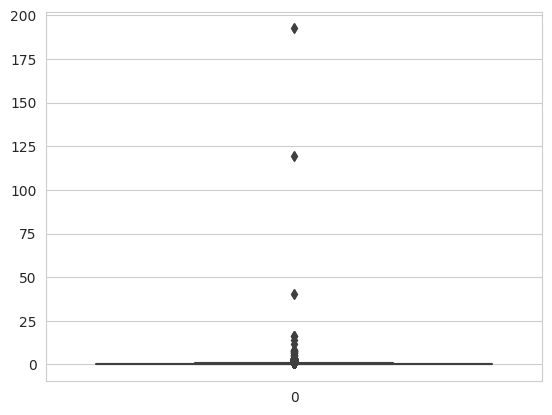

In [14]:
# Box Plot
import seaborn as sns

sns.boxplot(df['nearestStation'])

In [15]:
print(len(df_orig))
old_length = len(df_orig)

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

54067
54067 ==> 54067


In [16]:
df['tenure.tenureType'] = df['tenure.tenureType'].astype('category')

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

54067 ==> 54067


In [17]:
df.describe().T

count           mean            std            min  \
Price                54067.0  416448.380528  113505.624206  100000.000000   
bedrooms             52265.0      11.360145    2143.329175       1.000000   
bathrooms            50569.0       1.181534       0.413244       1.000000   
nearestStation       54067.0       0.442075       1.049040       0.000000   
location.latitude    54057.0      51.496130       0.076650      51.298317   
location.longitude   54067.0      -0.106239       0.718769      -0.498315   
latitude_deviation   54057.0       0.063545       0.042994       0.000000   
longitude_deviation  54067.0       0.133758       0.706214       0.000000   

                               25%            50%            75%  \
Price                325000.000000  425000.000000  500000.000000   
bedrooms                  1.000000       2.000000       2.000000   
bathrooms                 1.000000       1.000000       1.000000   
nearestStation            0.221778       0.361208       0.553963   
location.latitude        51.439070      51.499478      51.554067   
location.longitude       -0.212965      -0.105220      -0.012998   
latitude_deviation        0.027538       0.057198       0.093844   
longitude_deviation       0.044160       0.098877       0.192164   

                               max  
Price                600000.000000  
bedrooms             490000.000000  
bathrooms                12.000000  
nearestStation          192.431869  
location.latitude        51.683185  
location.longitude       51.558746  
latitude_deviation        0.201161  
longitude_deviation      51.663966

In [18]:
df.describe(include=['object', 'category'], exclude=[]).T

count unique        top   freq
tenure.tenureType  50413      4  LEASEHOLD  31582

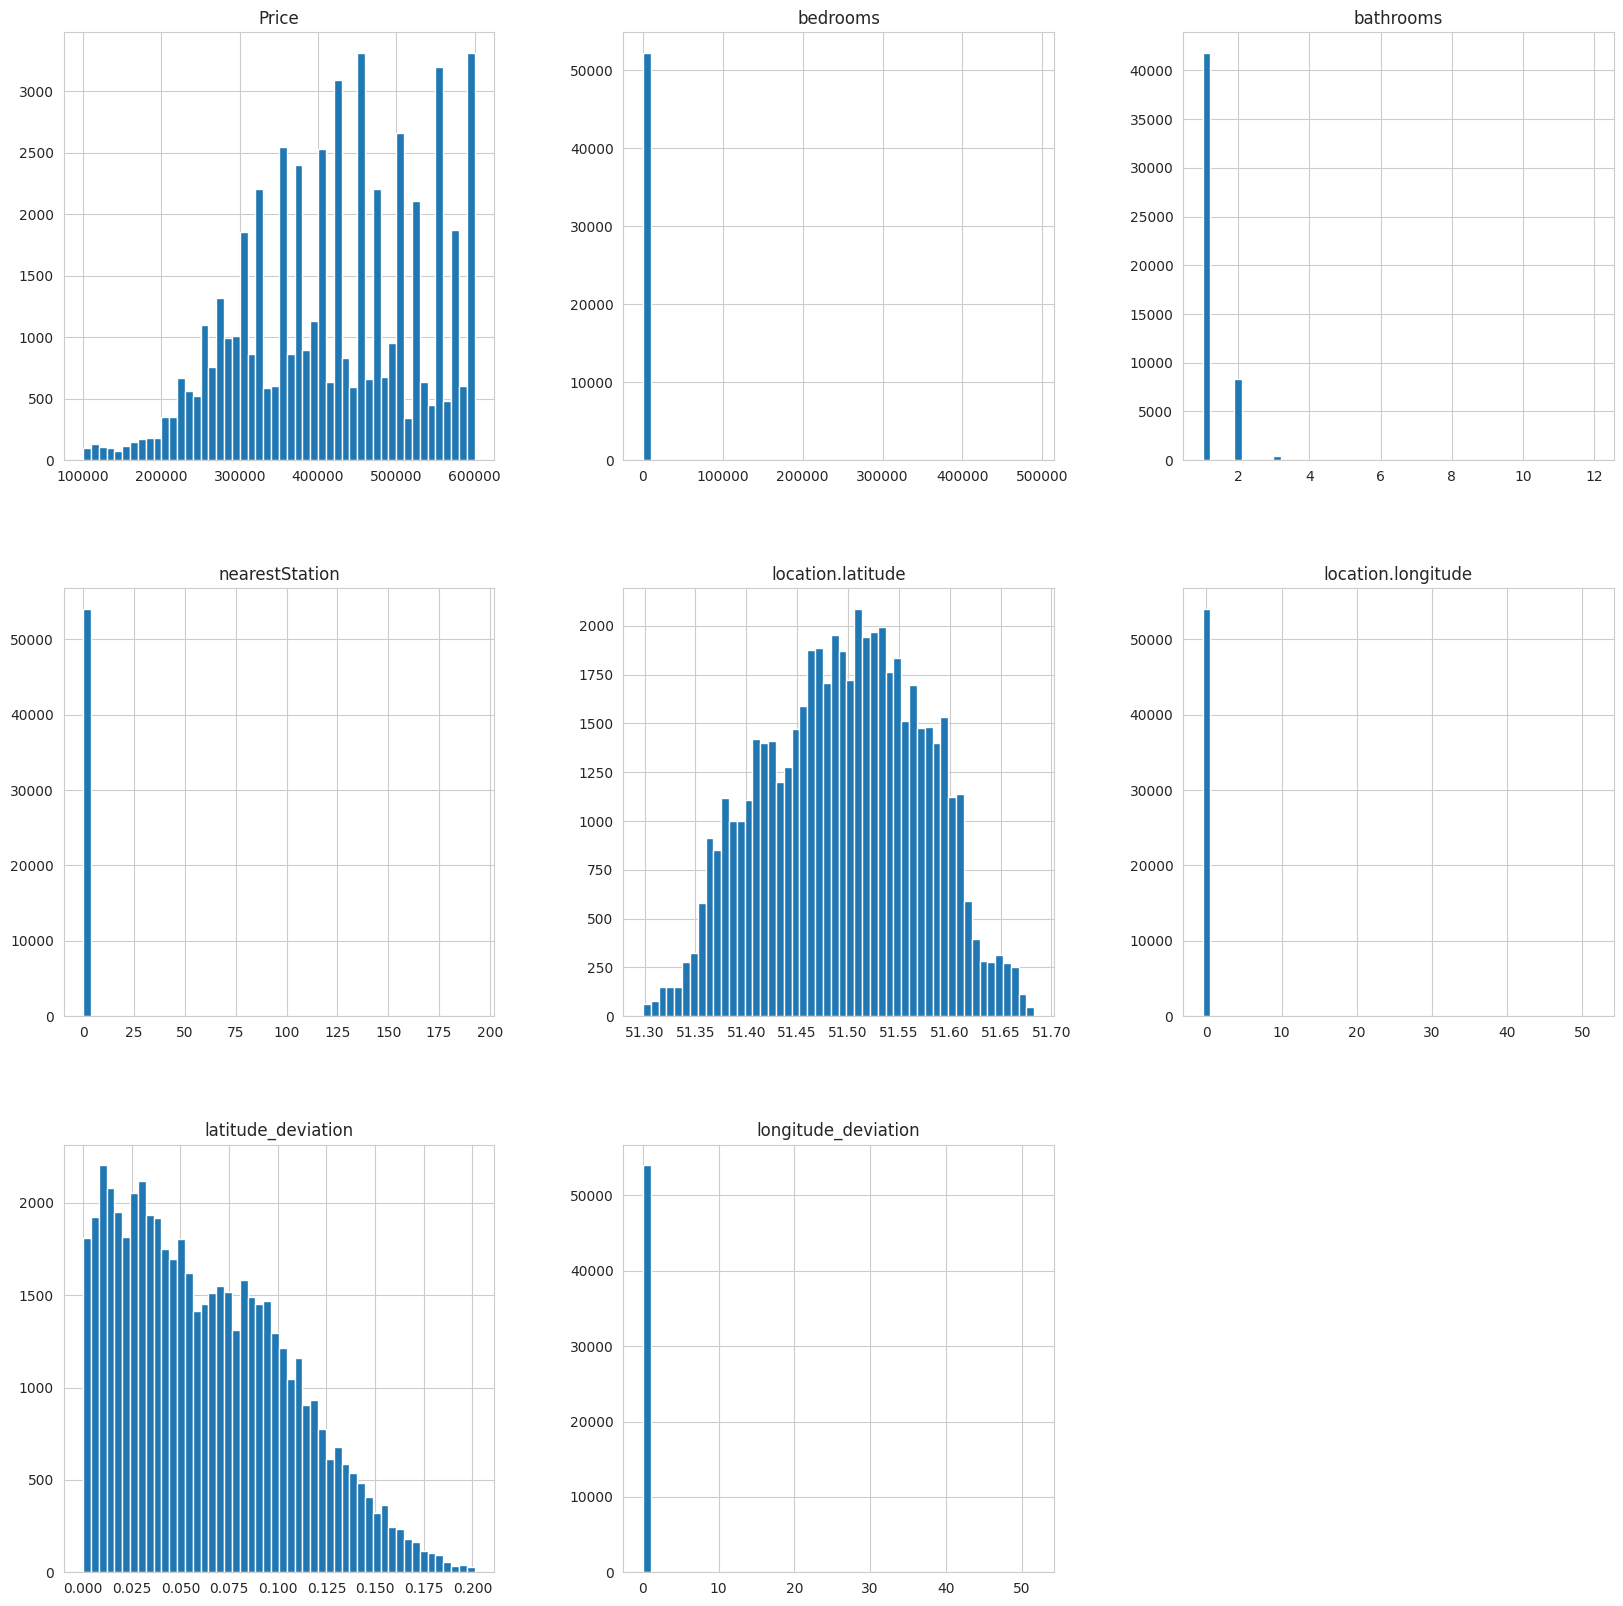

In [19]:
%matplotlib inline
df.hist(bins=50, figsize=(20, 20))
plt.show()

<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    IDENTIFY OUTLIERS


</h2>
</div>

In [20]:
df.isna().sum()

Price                     0
bedrooms               1802
bathrooms              3498
nearestStation            0
location.latitude        10
location.longitude        0
latitude_deviation       10
longitude_deviation       0
tenure.tenureType      3654
dtype: int64

In [21]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bedrooms'] > 5].sort_values('bedrooms', ascending=False)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
125513798  490000  490000.0        2.0        0.150384          51.580290   
125880485  600000       7.0        5.0        0.592204          51.440830   
125543333  550000       7.0        NaN        1.642956          51.594000   
119217689  525000       7.0        2.0        0.393151          51.538560   
124019570  600000       7.0        2.0        0.909304          51.529453   
84063621   600000       6.0        2.0        0.525190          51.662239   
123811142  600000       6.0        1.0        0.758594          51.474324   
125568515  575000       6.0        3.0        1.334739          51.527980   
125047877  525000       6.0        3.0        0.592597          51.659081   
125000246  525000       6.0        2.0        0.118946          51.489867   
124799777  520000       6.0        2.0        0.743722          51.479360   
124064753  599950       6.0        3.0        0.330673          51.392482   
123693851  535000       6.0        3.0        0.416445          51.643021   
84739572   600000       6.0        2.0        0.836096          51.396383   
122834111  499995       6.0        4.0        0.514528          51.482780   
122436188  600000       6.0        5.0        0.157157          51.516180   
121793234  500000       6.0        2.0        0.522288          51.552974   
120996098  560000       6.0        2.0        0.165819          51.369340   
120366419  400000       6.0        2.0        0.339003          51.451404   
120165197  550000       6.0        3.0        0.406018          51.543911   
116167328  600000       6.0        3.0        0.725541          51.460215   
115579406  550000       6.0        3.0        0.326105          51.506092   
111897098  580000       6.0        4.0        0.392721          51.545448   
125898833  575000       6.0        3.0        1.077764          51.449267   

           location.longitude  latitude_deviation  longitude_deviation  \
125513798           -0.340270            0.080812             0.235050   
125880485           -0.038410            0.058648             0.066810   
125543333            0.160060            0.094522             0.265280   
119217689            0.118210            0.039082             0.223430   
124019570            0.184820            0.029975             0.290040   
84063621            -0.035894            0.162761             0.069326   
123811142            0.131402            0.025154             0.236622   
125568515           -0.461629            0.028502             0.356409   
125047877           -0.042710            0.159603             0.062510   
125000246            0.055150            0.009611             0.160370   
124799777            0.079170            0.020118             0.184390   
124064753           -0.296887            0.106996             0.191667   
123693851           -0.048691            0.143543             0.056529   
84739572            -0.120228            0.103095             0.015008   
122834111            0.089120            0.016698             0.194340   
122436188            0.056490            0.016702             0.161710   
121793234            0.058253            0.053496             0.163473   
120996098           -0.114890            0.130138             0.009670   
120366419           -0.017425            0.048074             0.087795   
120165197            0.075780            0.044433             0.181000   
116167328           -0.335873            0.039263             0.230653   
115579406           -0.476882            0.006614             0.371662   
111897098            0.051230            0.045970             0.156450   
125898833            0.106676            0.050211             0.211896   

          tenure.tenureType  
125513798         LEASEHOLD  
125880485          FREEHOLD  
125543333          FREEHOLD  
119217689          FREEHOLD  
124019570          FREEHOLD  
84063621           FREEHOLD  
123811142          FREEHO

In [22]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bedrooms'] > 10].sort_values('bedrooms', ascending=False)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
125513798  490000  490000.0        2.0        0.150384           51.58029   

           location.longitude  latitude_deviation  longitude_deviation  \
125513798            -0.34027            0.080812              0.23505   

          tenure.tenureType  
125513798         LEASEHOLD

In [23]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['bathrooms'] > 5]

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
122875514  485000       3.0       12.0        0.095729          51.400012   
123034523  365000       1.0       11.0        0.242776          51.511447   

           location.longitude  latitude_deviation  longitude_deviation  \
122875514           -0.062682            0.099466             0.042538   
123034523            0.012305            0.011969             0.117525   

          tenure.tenureType  
122875514          FREEHOLD  
123034523               NaN

In [24]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['longitude_deviation'] > 1]

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
117726977  250000       NaN        NaN        0.204070                NaN   
118737587  600000       4.0        2.0        0.559261                NaN   
119410649  280000       2.0        2.0        0.060633                NaN   
120572951  300000       NaN        1.0        0.403894                NaN   
121441124  300000       NaN        NaN        0.141185                NaN   
122251739  400000       3.0        2.0        0.352386                NaN   
123704549  395000       4.0        2.0        0.499003                NaN   
124725866  395000       NaN        NaN        0.346325                NaN   
124725887  400000       NaN        NaN        0.392091                NaN   
124900562  220000       NaN        NaN        0.549313                NaN   

           location.longitude  latitude_deviation  longitude_deviation  \
117726977           51.416213                 NaN            51.521433   
118737587           51.476357                 NaN            51.581577   
119410649           51.558746                 NaN            51.663966   
120572951           51.400795                 NaN            51.506015   
121441124           51.521018                 NaN            51.626238   
122251739           51.467950                 NaN            51.573170   
123704549           51.470790                 NaN            51.576010   
124725866           51.419006                 NaN            51.524226   
124725887           51.475860                 NaN            51.581080   
124900562           51.537886                 NaN            51.643106   

          tenure.tenureType  
117726977         LEASEHOLD  
118737587          FREEHOLD  
119410649         LEASEHOLD  
120572951          FREEHOLD  
121441124         LEASEHOLD  
122251739          FREEHOLD  
123704549          FREEHOLD  
124725866          FREEHOLD  
124725887          FREEHOLD  
124900562          FREEHOLD

In [25]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['latitude_deviation'] > 1]

Empty DataFrame
Columns: [Price, bedrooms, bathrooms, nearestStation, location.latitude, location.longitude, latitude_deviation, longitude_deviation, tenure.tenureType]
Index: []

In [26]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['nearestStation'] > 20]

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
105719081  224995       3.0        2.0      192.431869          51.457055   
117858356  285000       2.0        NaN       40.309392          51.461170   
122768234  270000       3.0        2.0      119.325844          51.427000   

           location.longitude  latitude_deviation  longitude_deviation  \
105719081           -0.131578            0.042423             0.026358   
117858356            0.149245            0.038308             0.254465   
122768234            0.019000            0.072478             0.124220   

          tenure.tenureType  
105719081          FREEHOLD  
117858356          FREEHOLD  
122768234          FREEHOLD

In [27]:
# Identifying outliers, in order to try and verify (from the source data) that they are incorrect data.
df[df['nearestStation'] > 4].sort_values('nearestStation', ascending=False)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
105719081  224995       3.0        2.0      192.431869          51.457055   
122768234  270000       3.0        2.0      119.325844          51.427000   
117858356  285000       2.0        NaN       40.309392          51.461170   
118856216  285000       2.0        1.0       16.168861          51.536460   
119522684  360000       2.0        2.0       16.153746          51.654780   
113253098  260000       2.0        NaN       13.772327          51.499025   
122929250  205000       1.0        1.0       11.455267          51.494784   
85641123   440000       3.0        2.0        8.485819          51.496878   
124059935  375000       1.0        1.0        8.055191          51.566450   
120340466  550000       2.0        2.0        7.883041          51.561686   
85814571   110625       2.0        1.0        7.819520          51.551710   
85819356   116250       2.0        1.0        7.819520          51.551710   
122987912  399000       NaN        1.0        7.380915          51.430921   
119900342  250000       1.0        1.0        7.197700          51.514080   
117466274  325000       1.0        1.0        6.809012          51.572170   
124510442  120000       2.0        1.0        6.374483          51.533770   
124943663  430000       1.0        1.0        5.404072          51.602533   
125398232  428000       1.0        1.0        5.404072          51.602533   
108536084  499950       1.0        1.0        5.353237          51.580820   
117908912  550000       2.0        1.0        5.073295          51.614100   

           location.longitude  latitude_deviation  longitude_deviation  \
105719081           -0.131578            0.042423             0.026358   
122768234            0.019000            0.072478             0.124220   
117858356            0.149245            0.038308             0.254465   
118856216           -0.311704            0.036982             0.206484   
119522684           -0.041851            0.155302             0.063369   
113253098           -0.235200            0.000453             0.129980   
122929250           -0.035018            0.004694             0.070202   
85641123            -0.126700            0.002600             0.021480   
124059935           -0.260900            0.066972             0.155680   
120340466            0.076460            0.062208             0.181680   
85814571            -0.082730            0.052232             0.022490   
85819356            -0.082730            0.052232             0.022490   
122987912           -0.093650            0.068557             0.011570   
119900342           -0.070964            0.014602             0.034256   
117466274           -0.349820            0.072692             0.244600   
124510442           -0.140010            0.034292             0.034790   
124943663           -0.183021            0.103055             0.077801   
125398232           -0.183021            0.103055             0.077801   
108536084           -0.123510            0.081342             0.018290   
117908912           -0.421300            0.114622             0.316080   

          tenure.tenureType  
105719081          FREEHOLD  
122768234          FREEHOLD  
117858356          FREEHOLD  
118856216         LEASEHOLD  
119522684         LEASEHOLD  
113253098         LEASEHOLD  
122929250         LEASEHOLD  
85641123           FREEHOLD  
124059935         LEASEHOLD  
120340466         LEASEHOLD  
85814571          LEASEHOLD  
85819356          LEASEHOLD  
122987912         LEASEHOLD  
119900342         LEASEHOLD  
117466274         LEASEHOLD  
124510442               NaN  
124943663               NaN  
125398232               NaN  
108536084         LEASEHOLD  
117908912         LEASEHOLD

In [28]:
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[((df['longitude_deviation'] <= 1) & (df['latitude_deviation'] <= 1))]
df = df[(df['nearestStation'] <= 4)]

print(f"{old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

54067 ==> 49001


count           mean            std            min  \
Price                49001.0  421231.693516  110808.489080  100000.000000   
bedrooms             49001.0       1.981511       0.824562       1.000000   
bathrooms            49001.0       1.186670       0.413090       1.000000   
nearestStation       49001.0       0.435002       0.319408       0.000000   
location.latitude    49001.0      51.496412       0.077344      51.298317   
location.longitude   49001.0      -0.114255       0.156276      -0.498315   
latitude_deviation   49001.0       0.064417       0.042918       0.000000   
longitude_deviation  49001.0       0.123970       0.095576       0.000000   

                               25%            50%            75%  \
Price                339950.000000  425000.000000  500000.000000   
bedrooms                  1.000000       2.000000       2.000000   
bathrooms                 1.000000       1.000000       1.000000   
nearestStation            0.224470       0.364929       0.556456   
location.latitude        51.438116      51.499690      51.555611   
location.longitude       -0.211370      -0.103350      -0.011778   
latitude_deviation        0.028552       0.058601       0.094542   
longitude_deviation       0.043270       0.098830       0.192220   

                               max  
Price                600000.000000  
bedrooms                  7.000000  
bathrooms                 5.000000  
nearestStation            3.687893  
location.latitude        51.683185  
location.longitude        0.279726  
latitude_deviation        0.201161  
longitude_deviation       0.393095

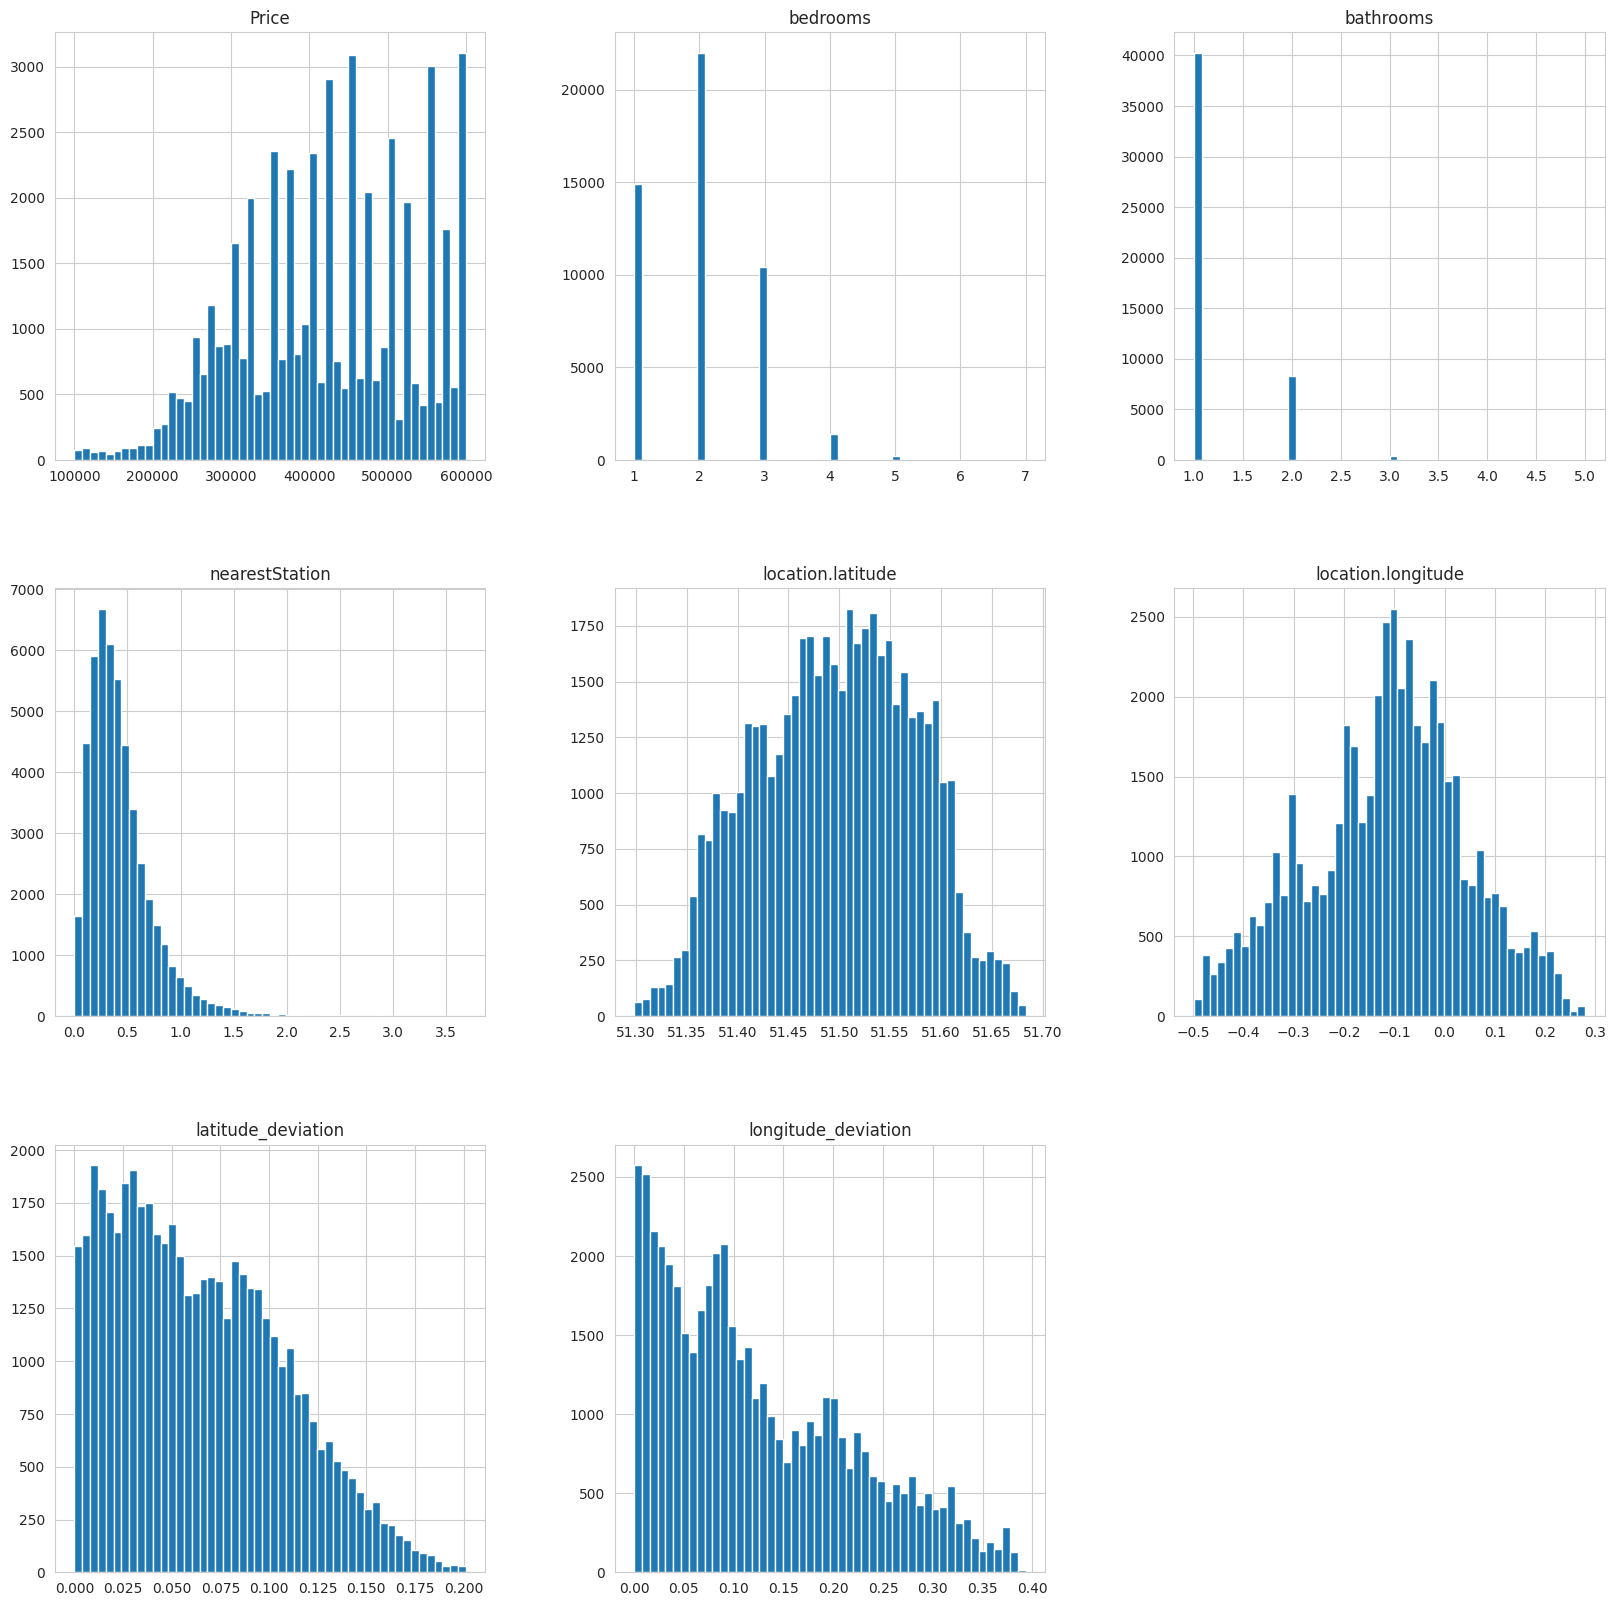

In [29]:
df.hist(bins=50, figsize=(20, 20))
plt.show()

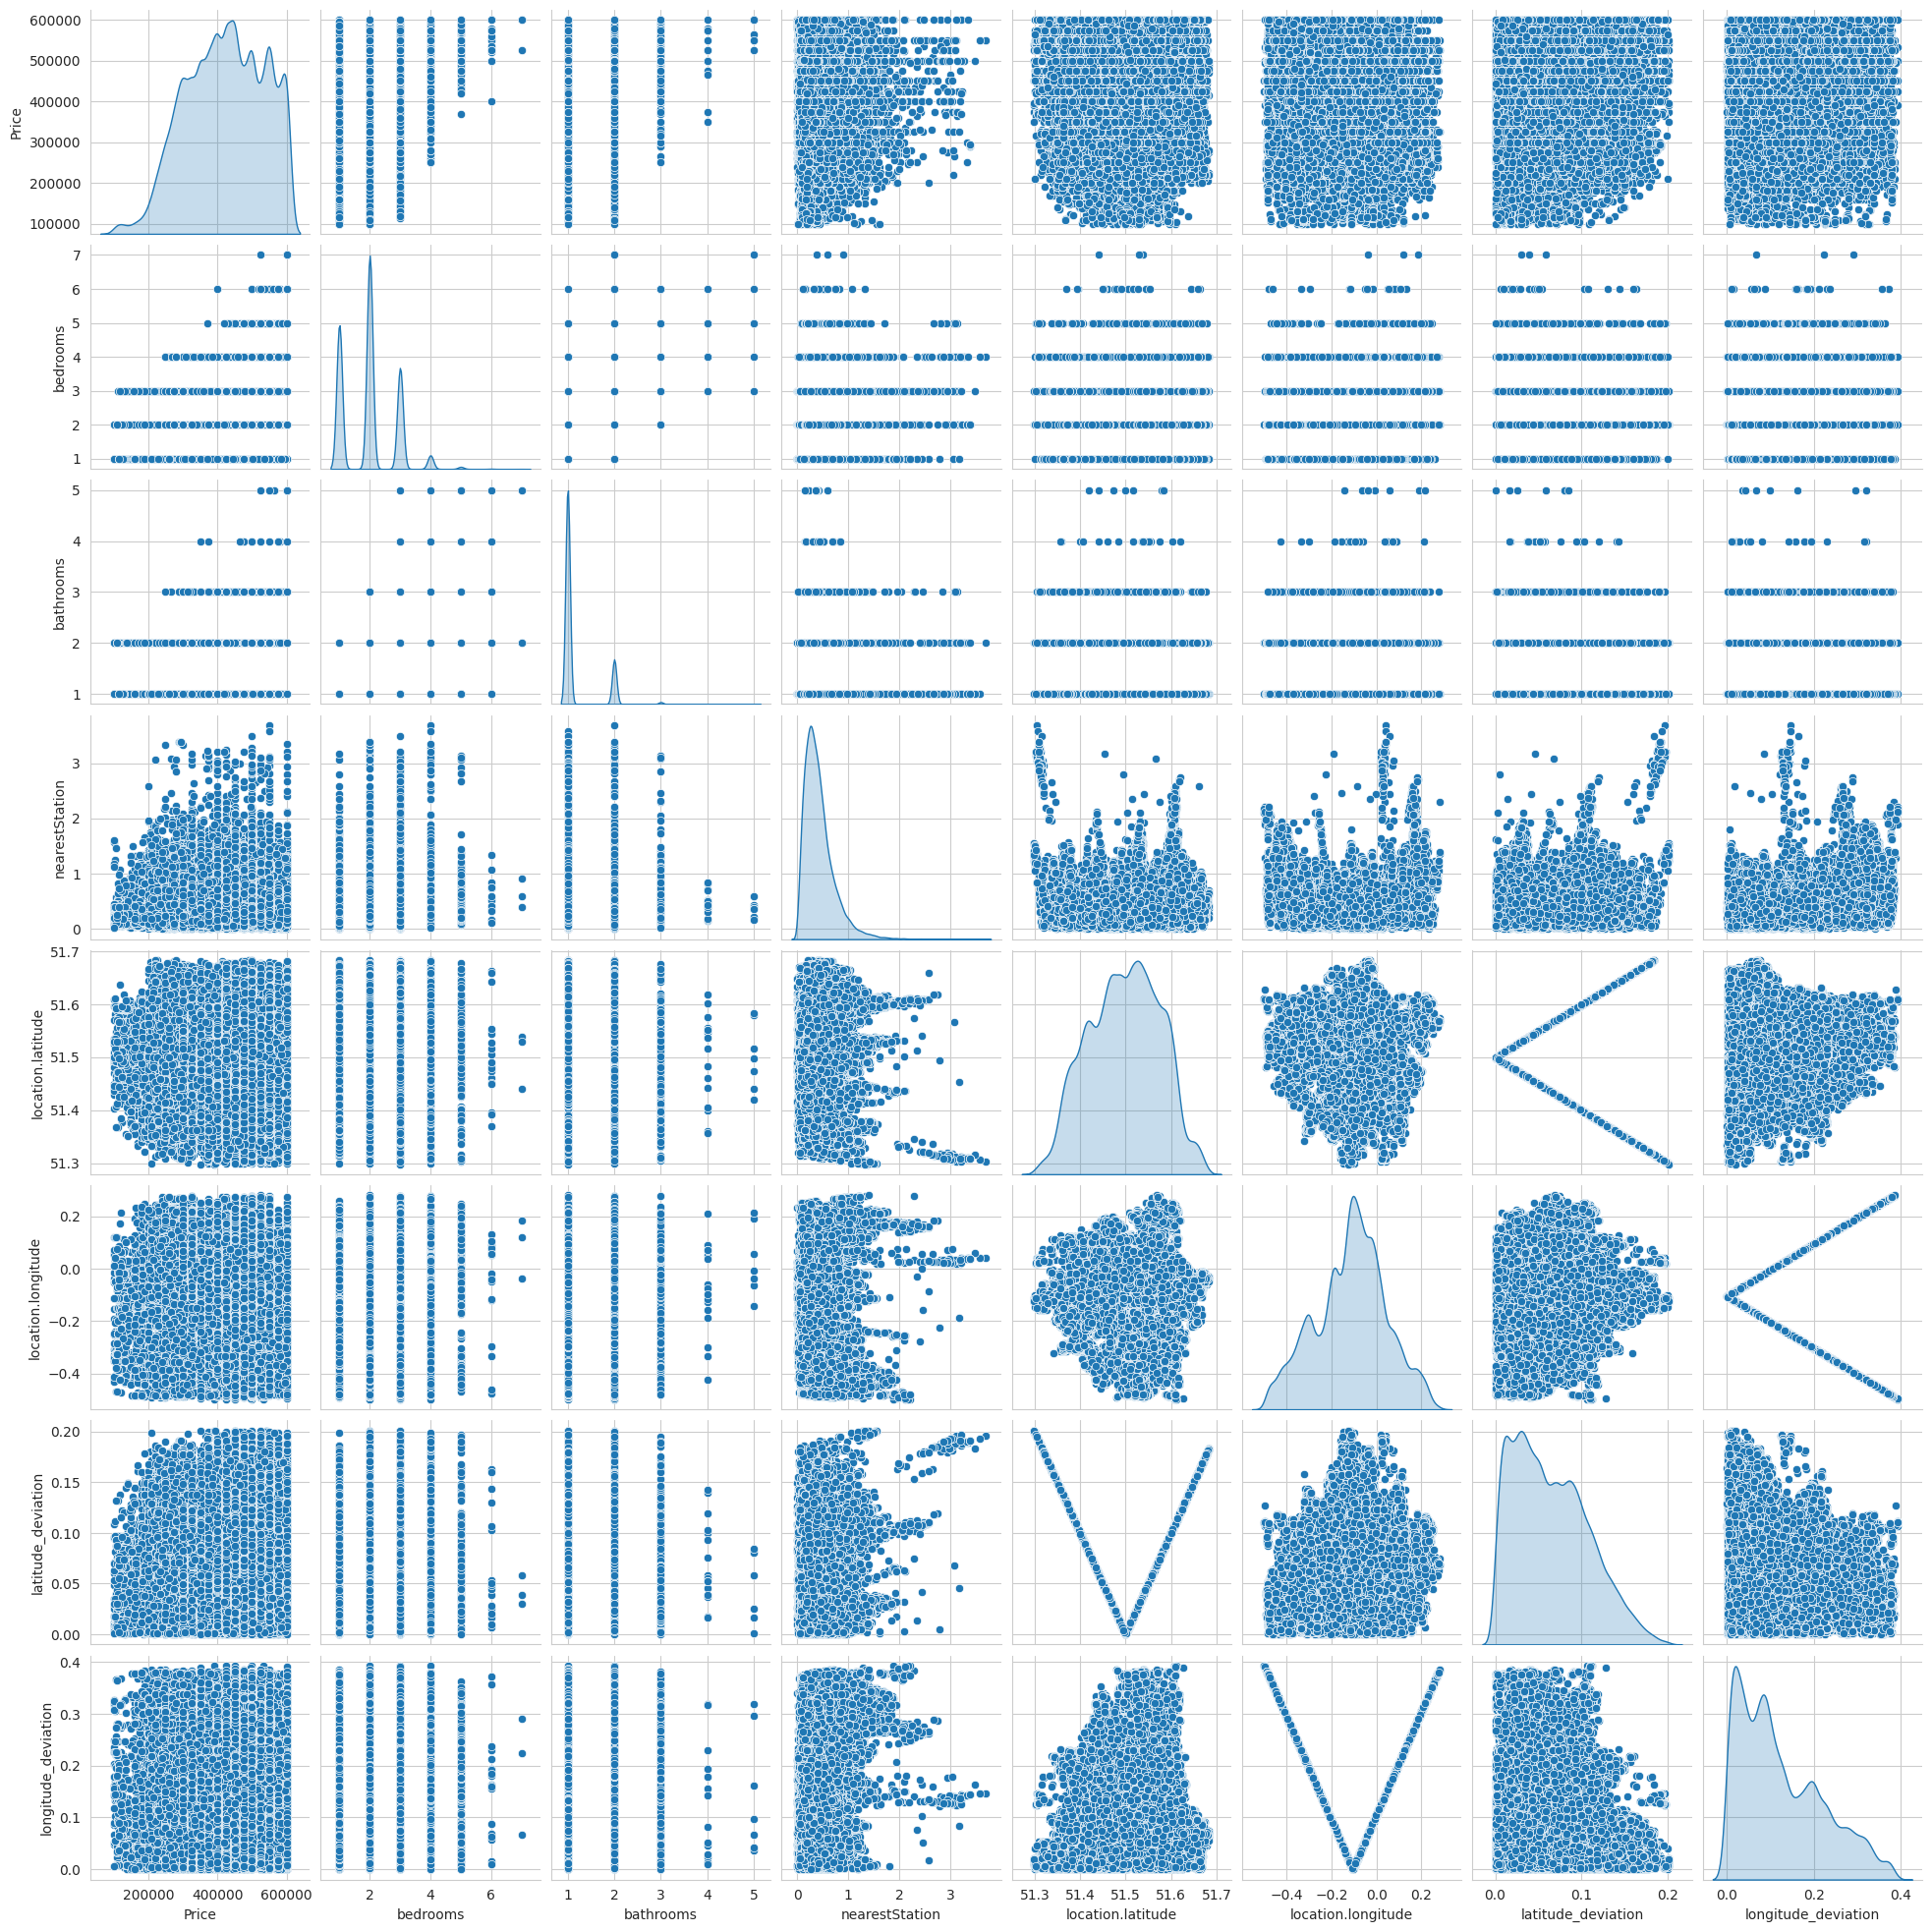

In [30]:
sns.pairplot(df, diag_kind='kde')

In [31]:
#df.isna().any()
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2871
dtype: int64

In [32]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

49001 ==> 46130


Price      bedrooms     bathrooms  nearestStation  \
count   46130.000000  46130.000000  46130.000000    46130.000000   
mean   421303.814286      1.980035      1.185736        0.434941   
std    110839.369263      0.823344      0.411908        0.319016   
min    100000.000000      1.000000      1.000000        0.000000   
25%    339950.000000      1.000000      1.000000        0.225120   
50%    425000.000000      2.000000      1.000000        0.365379   
75%    500000.000000      2.000000      1.000000        0.556132   
max    600000.000000      7.000000      5.000000        3.687893   

       location.latitude  location.longitude  latitude_deviation  \
count       46130.000000        46130.000000        46130.000000   
mean           51.496059           -0.114022            0.064628   
std             0.077508            0.155652            0.042923   
min            51.298317           -0.498315            0.000000   
25%            51.437530           -0.211284            0.028702   
50%            51.498409           -0.103070            0.058882   
75%            51.555673           -0.012035            0.094778   
max            51.683185            0.279726            0.201161   

       longitude_deviation  
count         46130.000000  
mean              0.123479  
std               0.095172  
min               0.000000  
25%               0.043251  
50%               0.098485  
75%               0.191522  
max               0.393095

In [33]:
df_features = df.drop(LABEL, axis=1)
df_features

bedrooms  bathrooms  nearestStation  location.latitude  \
14520525        3.0        1.0        0.274316          51.529950   
27953107        2.0        2.0        0.305845          51.549390   
33593487        2.0        1.0        0.438045          51.447180   
35271294        2.0        1.0        0.399307          51.449568   
44749111        2.0        1.0        0.410550          51.370050   
...             ...        ...             ...                ...   
126179018       2.0        1.0        0.682879          51.370651   
126179672       3.0        2.0        0.545665          51.357170   
126180107       2.0        1.0        0.191407          51.531415   
126180704       2.0        1.0        0.308609          51.543141   
126181118       2.0        1.0        0.238489          51.424589   

           location.longitude  latitude_deviation  longitude_deviation  \
14520525            -0.207020            0.030472             0.101800   
27953107            -0.482600            0.049912             0.377380   
33593487            -0.338770            0.052298             0.233550   
35271294            -0.140154            0.049910             0.034934   
44749111            -0.212410            0.129428             0.107190   
...                       ...                 ...                  ...   
126179018           -0.238346            0.128827             0.133126   
126179672           -0.074740            0.142308             0.030480   
126180107           -0.052964            0.031937             0.052256   
126180704            0.011498            0.043663             0.116718   
126181118           -0.206790            0.074889             0.101570   

           tenure.tenureType  
14520525           LEASEHOLD  
27953107           LEASEHOLD  
33593487            FREEHOLD  
35271294           LEASEHOLD  
44749111            FREEHOLD  
...                      ...  
126179018           FREEHOLD  
126179672          LEASEHOLD  
126180107          LEASEHOLD  
126180704          LEASEHOLD  
126181118  SHARE_OF_FREEHOLD  

[46130 rows x 8 columns]

In [34]:
use_one_hot_encoding_not_dummies = False

if use_one_hot_encoding_not_dummies:
    raise NotImplementedError('not implemented one hot encoding yet')

    #from sklearn.preprocessing import OneHotEncoder
    #tenure_encoder = OneHotEncoder()
    #df_tenure_type = tenure_encoder.fit_transform(df_features[['tenure.tenureType']])
else:
    for column in categories:
        df_features = pd.concat([df_features, pd.get_dummies(df_features[column], prefix=column, drop_first=True)],
                                axis=1)
        df_features.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

features_corr = df_features.corr()
features_corr

bedrooms  bathrooms  nearestStation  \
bedrooms                             1.000000   0.330285        0.244848   
bathrooms                            0.330285   1.000000        0.048645   
nearestStation                       0.244848   0.048645        1.000000   
location.latitude                    0.003600  -0.004528        0.023591   
location.longitude                   0.119263   0.017167        0.044317   
latitude_deviation                   0.196510   0.035089        0.162096   
longitude_deviation                  0.179738   0.076605        0.318669   
tenure.tenureType_FREEHOLD           0.591623   0.083135        0.313782   
tenure.tenureType_LEASEHOLD         -0.459182  -0.035755       -0.228043   
tenure.tenureType_SHARE_OF_FREEHOLD -0.113899  -0.059040       -0.083624   

                                     location.latitude  location.longitude  \
bedrooms                                      0.003600            0.119263   
bathrooms                                    -0.004528            0.017167   
nearestStation                                0.023591            0.044317   
location.latitude                             1.000000            0.095611   
location.longitude                            0.095611            1.000000   
latitude_deviation                           -0.121266            0.047136   
longitude_deviation                           0.187440           -0.169904   
tenure.tenureType_FREEHOLD                    0.002758            0.138159   
tenure.tenureType_LEASEHOLD                   0.024928           -0.070704   
tenure.tenureType_SHARE_OF_FREEHOLD          -0.041265           -0.081718   

                                     latitude_deviation  longitude_deviation  \
bedrooms                                       0.196510             0.179738   
bathrooms                                      0.035089             0.076605   
nearestStation                                 0.162096             0.318669   
location.latitude                             -0.121266             0.187440   
location.longitude                             0.047136            -0.169904   
latitude_deviation                             1.000000            -0.186578   
longitude_deviation                           -0.186578             1.000000   
tenure.tenureType_FREEHOLD                     0.224370             0.272988   
tenure.tenureType_LEASEHOLD                   -0.209769            -0.174713   
tenure.tenureType_SHARE_OF_FREEHOLD            0.010552            -0.108389   

                                     tenure.tenureType_FREEHOLD  \
bedrooms                                               0.591623   
bathrooms                                              0.083135   
nearestStation                                         0.313782   
location.latitude                                      0.002758   
location.longitude                                     0.138159   
latitude_deviation                                     0.224370   
longitude_deviation                                    0.272988   
tenure.tenureType_FREEHOLD                             1.000000   
tenure.tenureType_LEASEHOLD                           -0.759896   
tenure.tenureType_SHARE_OF_FREEHOLD                   -0.216903   

                                     tenure.tenureType_LEASEHOLD  \
bedrooms                                               -0.459182   
bathrooms                                              -0.035755   
nearestStation                                         -0.228043   
location.latitude                                       0.024928   
location.longitude                                     -0.070704   
latitude_deviation                                     -0.209769   
longitude_deviation                                    -0.174713   
tenure.tenureType_FREEHOLD                             -0.759896   
tenure.tenureType_LEASEHOLD                             1.000000   
tenure.tenureType_SHARE_OF_FREEHOLD       

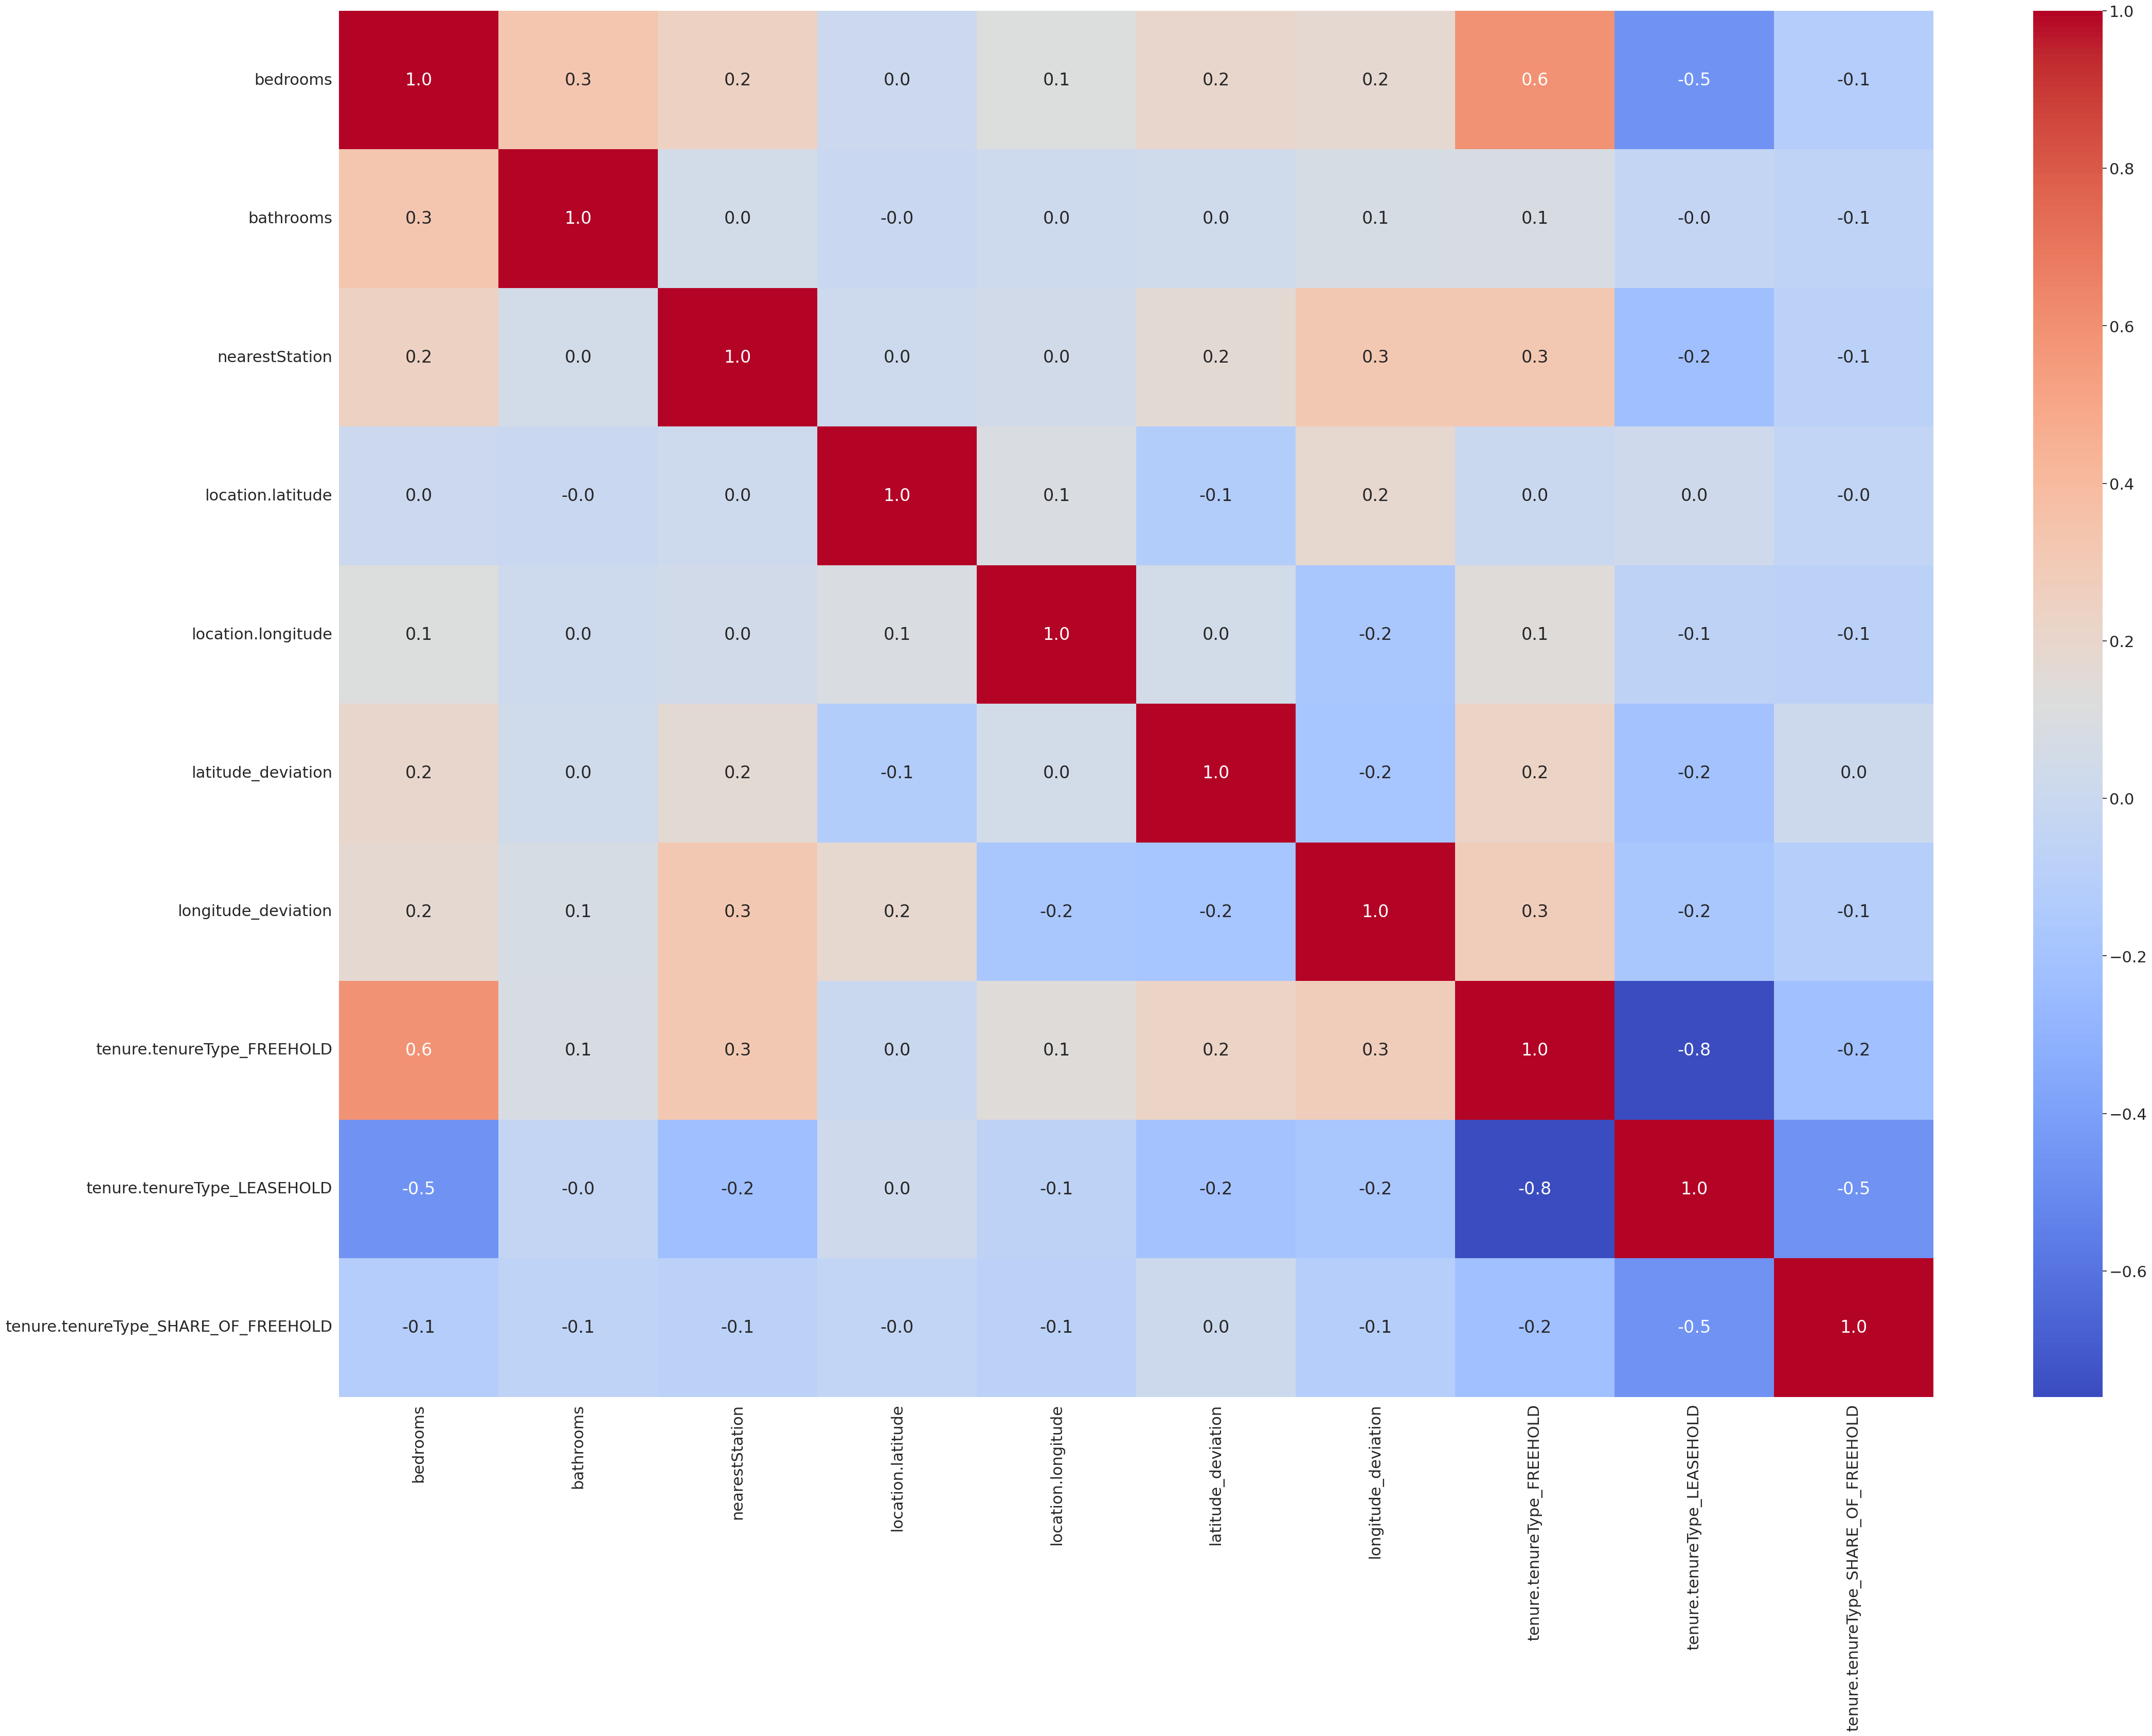

In [35]:
sns.set(font_scale=2)
plt.figure(figsize=(50, 35))
ax = sns.heatmap(features_corr, annot=True, fmt='.1f', cmap='coolwarm')

In [36]:
data_corr = df.corr()
data_corr_dict = data_corr["Price"].sort_values(ascending=False).to_dict()
data_corr_dict

{'Price': 1.0,
 'bedrooms': 0.46534652975639884,
 'bathrooms': 0.2529757772882512,
 'location.latitude': 0.053921445553891036,
 'nearestStation': -0.009356555855753533,
 'location.longitude': -0.06355664066241672,
 'latitude_deviation': -0.07579877701731129,
 'longitude_deviation': -0.07931783113479365}

In [37]:
#print the most positively correlated features
pos_corr = {k: v for k, v in data_corr_dict.items() if v > 0.1 and v != 1}
pos_corr

{'bedrooms': 0.46534652975639884, 'bathrooms': 0.2529757772882512}

In [38]:
#print the most negatively correlated features
neg_corr = {k: v for k, v in data_corr_dict.items() if v < -0.1}
neg_corr

{}

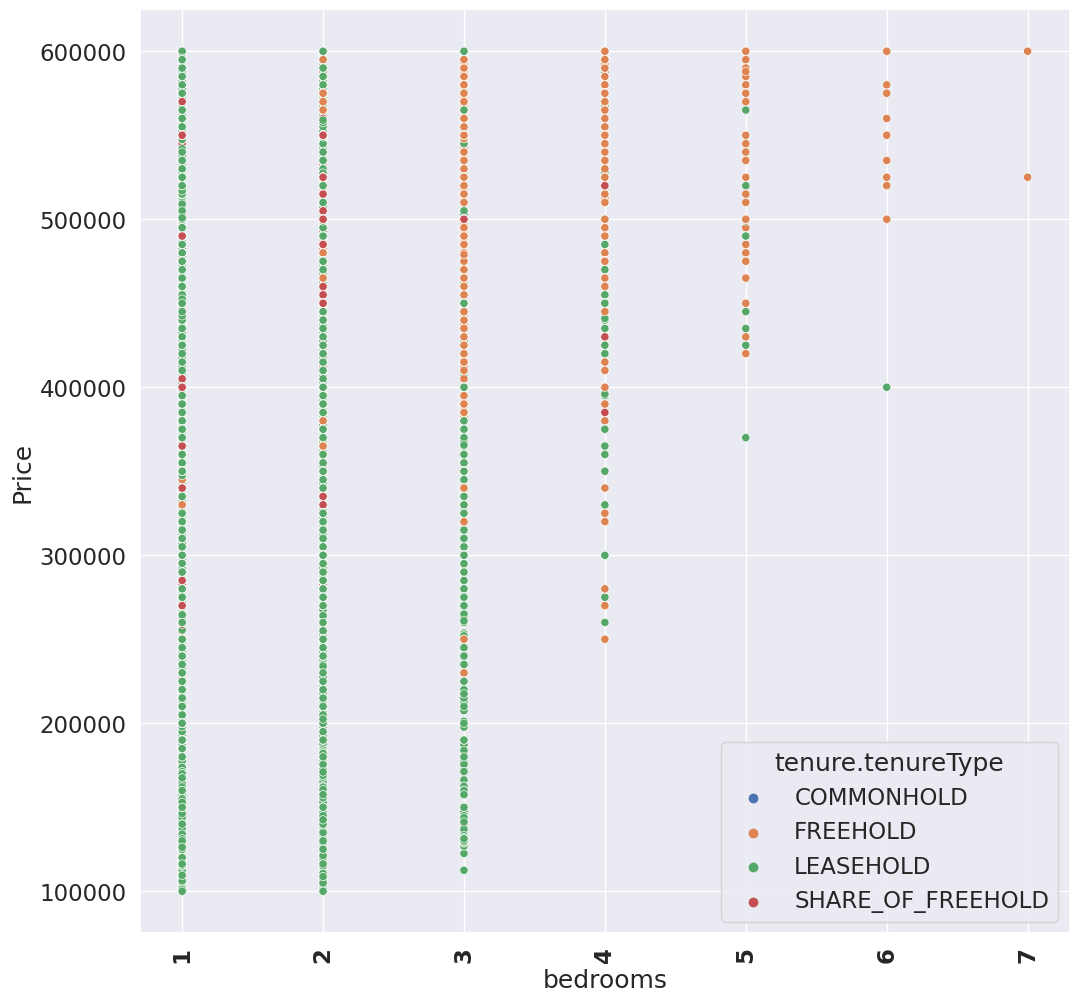

In [39]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='bedrooms', y='Price', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

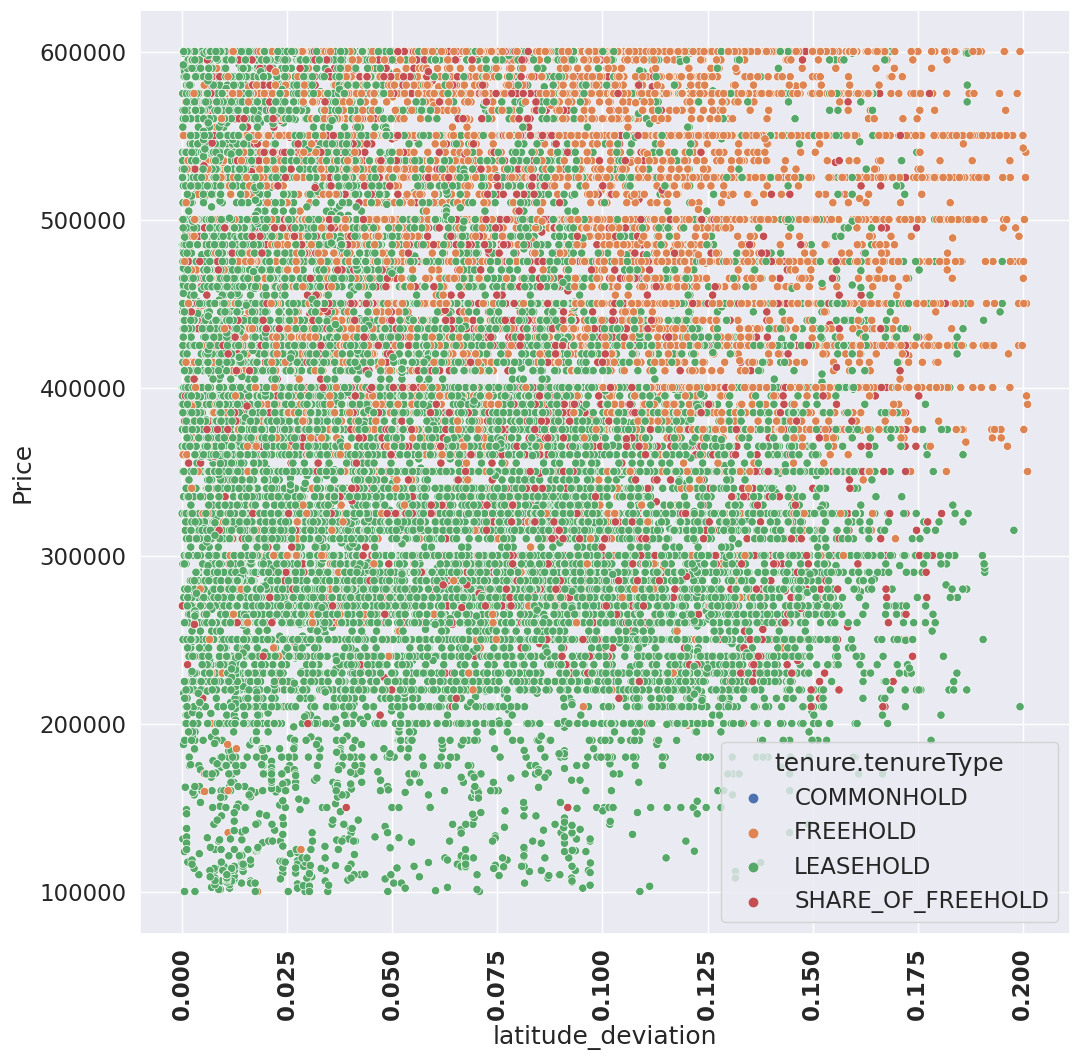

In [40]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='latitude_deviation', y='Price', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

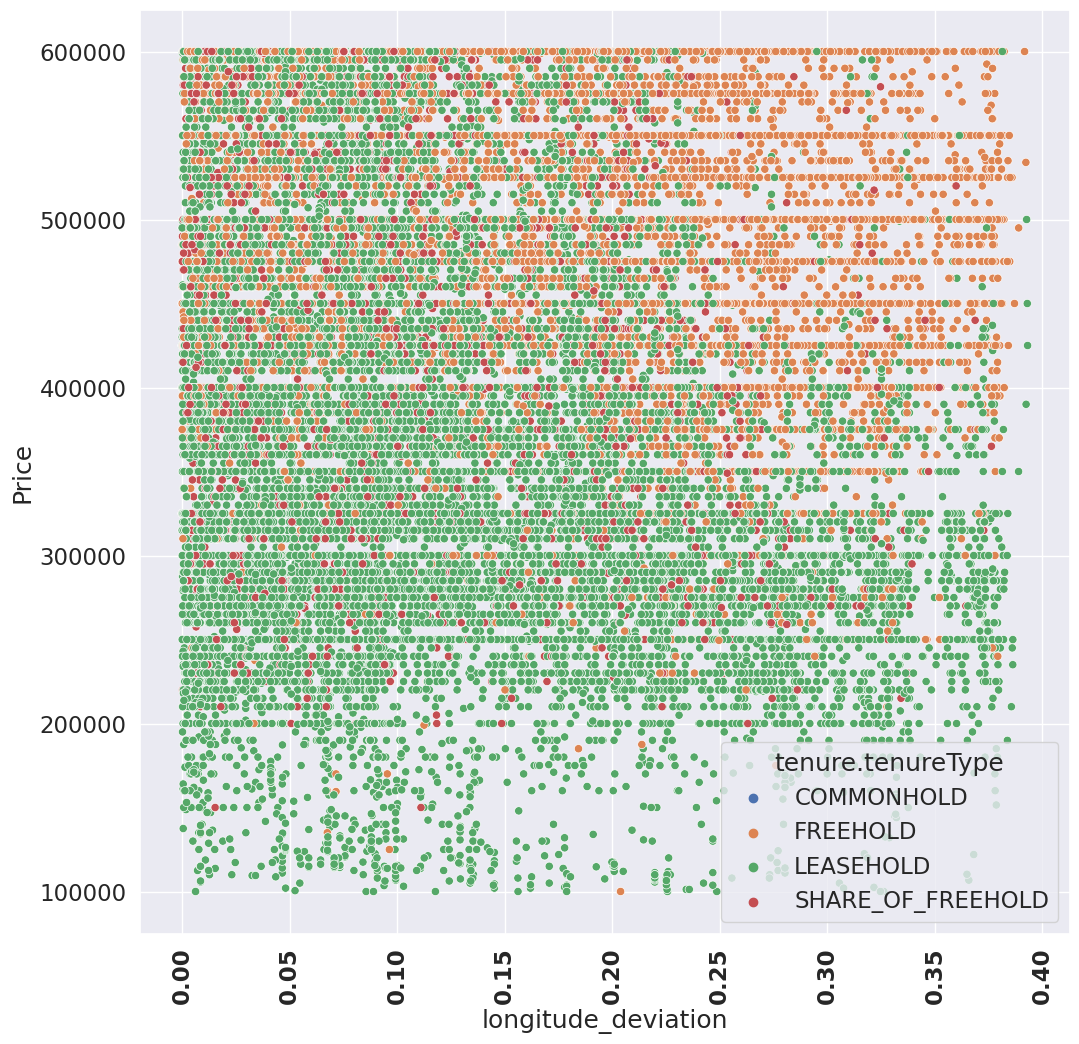

In [41]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='longitude_deviation', y='Price', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

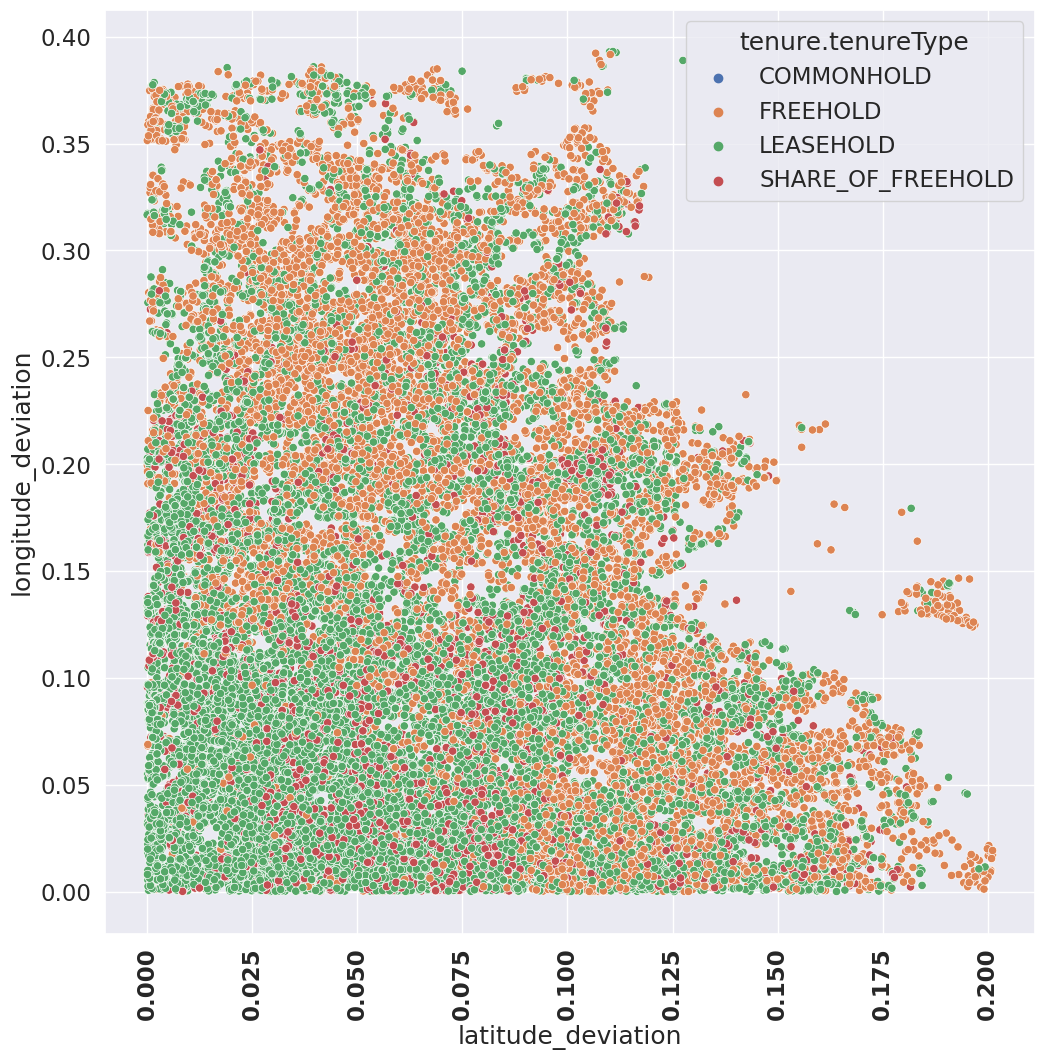

In [42]:
plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='latitude_deviation', y='longitude_deviation', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

<div id = 3 style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#b08888;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px;
           display:flex;
            justify-content:center;">

<h2 style="padding: 2rem;
              color:white;
          text-align:center;
          margin:0 auto;
          ">
    Exploration for imputation


</h2>
</div>

In [43]:
df['central_distance'] = (df['latitude_deviation'] ** 2 + df['longitude_deviation'] ** 2) ** 0.5
df

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
14520525   550000       3.0        1.0        0.274316          51.529950   
27953107   400000       2.0        2.0        0.305845          51.549390   
33593487   579950       2.0        1.0        0.438045          51.447180   
35271294   370000       2.0        1.0        0.399307          51.449568   
44749111   475000       2.0        1.0        0.410550          51.370050   
...           ...       ...        ...             ...                ...   
126179018  575000       2.0        1.0        0.682879          51.370651   
126179672  600000       3.0        2.0        0.545665          51.357170   
126180107  419999       2.0        1.0        0.191407          51.531415   
126180704  475000       2.0        1.0        0.308609          51.543141   
126181118  525000       2.0        1.0        0.238489          51.424589   

           location.longitude  latitude_deviation  longitude_deviation  \
14520525            -0.207020            0.030472             0.101800   
27953107            -0.482600            0.049912             0.377380   
33593487            -0.338770            0.052298             0.233550   
35271294            -0.140154            0.049910             0.034934   
44749111            -0.212410            0.129428             0.107190   
...                       ...                 ...                  ...   
126179018           -0.238346            0.128827             0.133126   
126179672           -0.074740            0.142308             0.030480   
126180107           -0.052964            0.031937             0.052256   
126180704            0.011498            0.043663             0.116718   
126181118           -0.206790            0.074889             0.101570   

           tenure.tenureType  central_distance  
14520525           LEASEHOLD          0.106263  
27953107           LEASEHOLD          0.380666  
33593487            FREEHOLD          0.239334  
35271294           LEASEHOLD          0.060921  
44749111            FREEHOLD          0.168051  
...                      ...               ...  
126179018           FREEHOLD          0.185254  
126179672          LEASEHOLD          0.145536  
126180107          LEASEHOLD          0.061243  
126180704          LEASEHOLD          0.124618  
126181118  SHARE_OF_FREEHOLD          0.126194  

[46130 rows x 10 columns]

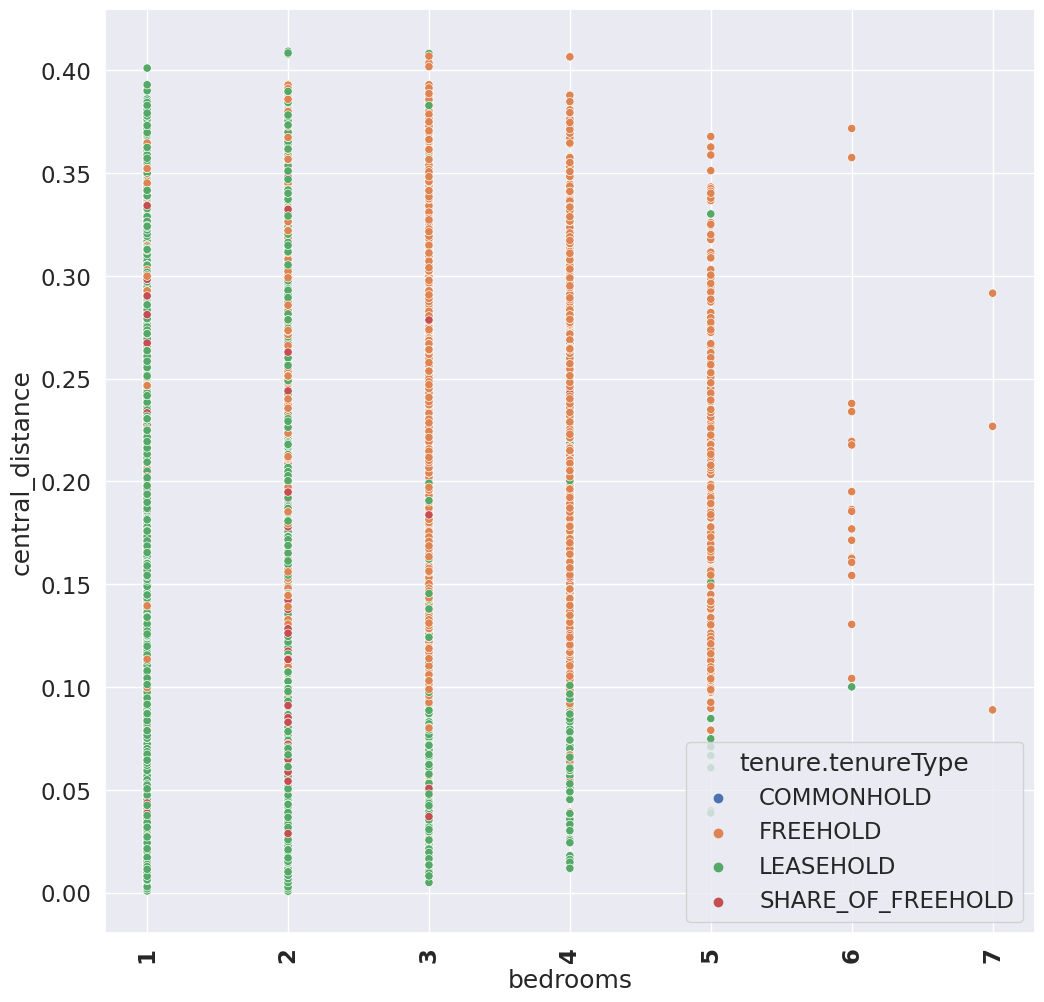

In [44]:

plt.figure(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.scatterplot(x='bedrooms', y='central_distance', data=df, hue='tenure.tenureType')
plt.xticks(weight='bold', rotation=90)
plt.show()

In [45]:
#df.groupby(['tenure.tenureType','bedrooms']).agg({'bedrooms':['mean','min','max']})
df.groupby(['tenure.tenureType', 'bedrooms']).agg('count')

Price  bathrooms  nearestStation  \
tenure.tenureType bedrooms                                     
COMMONHOLD        1.0           2          2               2   
                  2.0           5          5               5   
                  3.0           0          0               0   
                  4.0           0          0               0   
                  5.0           0          0               0   
                  6.0           0          0               0   
                  7.0           0          0               0   
FREEHOLD          1.0         342        342             342   
                  2.0        3271       3271            3271   
                  3.0        7035       7035            7035   
                  4.0        1129       1129            1129   
                  5.0         194        194             194   
                  6.0          17         17              17   
                  7.0           3          3               3   
LEASEHOLD         1.0       11719      11719           11719   
                  2.0       14457      14457           14457   
                  3.0        2338       2338            2338   
                  4.0         157        157             157   
                  5.0          11         11              11   
                  6.0           1          1               1   
                  7.0           0          0               0   
SHARE_OF_FREEHOLD 1.0        1978       1978            1978   
                  2.0        3023       3023            3023   
                  3.0         423        423             423   
                  4.0          25         25              25   
                  5.0           0          0               0   
                  6.0           0          0               0   
                  7.0           0          0               0   

                            location.latitude  location.longitude  \
tenure.tenureType bedrooms                                          
COMMONHOLD        1.0                       2                   2   
                  2.0                       5                   5   
                  3.0                       0                   0   
                  4.0                       0                   0   
                  5.0                       0                   0   
                  6.0                       0                   0   
                  7.0                       0                   0   
FREEHOLD          1.0                     342                 342   
                  2.0                    3271                3271   
                  3.0                    7035                7035   
                  4.0                    1129                1129   
                  5.0                     194                 194   
                  6.0                      17                  17   
                  7.0                       3                   3   
LEASEHOLD         1.0                   11719               11719   
                  2.0                   14457               14457   
                  3.0                    2338                2338   
                  4.0                     157                 157   
                  5.0                      11                  11   
                  6.0                       1                   1   
                  7.0                       0                   0   
SHARE_OF_FREEHOLD 1.0                    1978                1978   
                  2.0                    3023                3023   
                  3.0                     423                 423   
                  4.0                      25                  25   
                  5.0                       0                   0   
                  6.0                       0                   0   
                  7.0                       0                   0   

                            latitude